---
title: "Predict Protein-Protein Interactions with GraphSAGE"
date: "03/06/2024"
format:
    html:
        toc: true
        highlight-style: ayu
bibliography: references.bib
---

In [1]:
import random
from tqdm.notebook import tqdm, trange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import copy

import torch
from torch import nn, optim, Tensor
import torch.nn.functional as F

from torch_sparse import SparseTensor, matmul, set_diag
from torch_geometric.utils import negative_sampling
from torch_geometric.data import Dataset, download_url, extract_zip, Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType, OptTensor)
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax
import torch_scatter

from Bio import SeqIO

import zipfile
import os
import os.path as osp
import io

from proteinbert import load_pretrained_model
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs
import tensorflow as tf

This is the second of a *Protein Embedding with ProteinBERT and STRING*. On this part, we are gonna build a graph neural network (GNN) to update the embeddings of PorteinBERT with the information about the STRING network.

We will keep using the **Unfolded protein binding** (GO:0051082) ontology which belongs to the heat shock response. As before, the reason is because this was a gene set that appears significant on my thesis (Functional analysis of transcriptomes of *Coffea arabica* L. related to thermal stress) and because I don't have much power on my laptop.

## Creating and Loading the Unfolded Protein Binding Dataset

Before creating the neural network, we need data. So, for this I downloaded 60 plant species as zip files from STRING database. The reason I chooosed only plants, is because the heat shock proteins on plants are compartmentalized. This means, that there are specific heat shock proteins for the chloroplat, nucleus, mitocondria, plastids and cytoplasm. Using only plants in this case will result in a better training for this small part of the metabolism.

Other important thing to mention is that due to the size of the plants networks and the capacities of my laptop, I'm only using the **Unfolded protein binding** for these 60 species. If you have enough computing resources, you can try using the complete network from all these 60 species to train a robust model.

Great! Once downloaded the data, we need to create a dataset that pytorch geometric can use. For this, we need to use the [Dataset](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html#creating-graph-datasets) object from pytorch geometric. 

See the code below:

In [2]:

class UnfoldedProteinBinding(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        self.batch_size = 2 # adapt it according to your ram and gpu memmory
        super(UnfoldedProteinBinding, self).__init__(root, transform, pre_transform, pre_filter)
        

    @property
    def raw_file_names(self):
        return self._get_zip_files()
    
    def _get_zip_files(self):

        files = os.listdir(self.raw_dir)

        zip_files = [f for f in files if f.endswith(".zip")]
        return zip_files

    @property
    def processed_file_names(self):
        
        num_zip_files = len(self.raw_file_names)

        return [f"data_{i}.pt" for i in range(num_zip_files)]

    def download(self):
        # Download to `self.raw_dir`.
        pass

    def process(self):

        # gpu device only on linux system
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if len(gpus) > 0:
            try:
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
            except RuntimeError as e:
                print(e)
        else:
            print(f"Not gpus available")
            if os.name == "nt":
                print("Not gpus detected because you are using Windows system, Device: CPU")

        # check that we already processed the files
        if len(os.listdir(self.processed_dir)) == len(self.raw_file_names)+2:
            pass

        else:
                
            for species in self.raw_paths:

                print(species)

                # reading interactions from tsv file
                with zipfile.ZipFile(species, 'r') as z:
        
                    file_names = z.namelist()
                    
                    tsv_files = [file for file in file_names if file.endswith('interactions.tsv')]

                    for tsv_file in tsv_files:
                        with z.open(tsv_file) as f:
                            df = pd.read_csv(f, sep='\t')

                # reading fasta file
                with zipfile.ZipFile(species, 'r') as z:
    
                    file_names = z.namelist()
                    
                    tsv_files = [file for file in file_names if file.endswith('protein_sequences.fa')]

                    for tsv_file in tsv_files:
                        with z.open(tsv_file) as f:
                            f_text = io.TextIOWrapper(f)
                            protein_sequences_dict = self._read_proteins_from_fasta(f_text)
                
                # get unique proteins
                unique_proteins = set(df['node1_string_id']).union(set(df['node2_string_id']))

                # filter unique proteins on a dict
                filtered_protein_dict = {protein: seq for protein, seq in protein_sequences_dict.items() if protein in unique_proteins}

                # getting the larger sequence for the proteinbert embedding
                sequences = list(filtered_protein_dict.values())
                # protein_names = list(filtered_protein_dict.keys())
                longest_sequence_length = max(len(seq) for seq in sequences)

                # use protein bert to get embeddings
                batch_size = self.batch_size  # Adjust based on your GPU memory
                seq_len = longest_sequence_length+2
                global_embeds = []
                local_embeds = []

                for i in range(0, len(sequences), batch_size):

                    batch_seqs = sequences[i:i + batch_size]
                    local_representation, global_representation = self._get_embeddings(batch_seqs, seq_len=seq_len, batch_size=batch_size)
                    global_embeds.extend(global_representation)
                    local_embeds.extend(local_representation)
                
                global_embeds = np.array(global_embeds)
                local_embeds = np.array(local_embeds)

                # encode the protein names

                lbl_protein = preprocessing.LabelEncoder()

                df.node1_string_id = lbl_protein.fit_transform(df.node1_string_id.values)
                df.node2_string_id = lbl_protein.fit_transform(df.node2_string_id.values)

                # generate edge index

                edge_index = self._load_edge_csv(df=df, src_index_col="node1_string_id", dst_index_col="node2_string_id", link_index_col="combined_score")
                edge_index = torch.LongTensor(edge_index)

                # get class for the graph

                y = self._find_species_classes(self.root+"/raw/species.xlsx",species).values
                index = y.copy()[0]
                y = torch.Tensor(y).to(torch.long)
                
                # create pytorch geometric data

                data = Data(x=global_embeds,edge_index=edge_index, y=y)
                
                # save as .pt file according to the index (class)
                torch.save(data, osp.join(self.processed_dir,f"data_{index}.pt"))

           
    
    def _read_proteins_from_fasta(self, fasta_file):

        protein_dict = {}
        for record in SeqIO.parse(fasta_file, "fasta"):
            protein_dict[record.id] = str(record.seq)
        return protein_dict
    
    def _get_embeddings(self, seq, seq_len=512, batch_size=1):

        pretrained_model_generator, input_encoder = load_pretrained_model()
        model = get_model_with_hidden_layers_as_outputs(pretrained_model_generator.create_model(seq_len=seq_len))
        encoded_x = input_encoder.encode_X(seq, seq_len)
        local_representations, global_representations = model.predict(encoded_x, batch_size=batch_size)

        return local_representations, global_representations
    
    def _load_edge_csv(self, df, src_index_col, dst_index_col, link_index_col):
    
        edge_index= None
        src = [protein1 for protein1 in df[src_index_col]]
        dst = [protein2 for protein2 in df[dst_index_col]]

        edge_attr = torch.from_numpy(df[link_index_col].values).view(-1,1)

        edge_index = [[], []]
        for i in range(edge_attr.shape[0]):
            if edge_attr[i]:
                edge_index[0].append(src[i])
                edge_index[1].append(dst[i])
        return edge_index
    
    def _find_species_classes(self, file_path, species_path):
    # Load the Excel file into a pandas DataFrame        
        df = pd.read_excel(file_path)

        # Ensure the columns 'species' and 'class' exist
        if 'species' not in df.columns or 'class' not in df.columns:
            raise ValueError("The input file must contain 'species' and 'class' columns.")

        # Identify rows where "scientific name" is present in the "species" column (case insensitive)
        extract_pattern = [i.split("\\") for i in species_path.split("_")[0:2]]
        extract_pattern = [i[-1] for i in extract_pattern]
        extract_pattern = " ".join(extract_pattern)
        print(f"Extracted pattern: {extract_pattern}")

        mask = df['species'].str.contains(extract_pattern, case=False, na=False)

        # Return the corresponding "class" values
        result = df.loc[mask, 'class']
        return result


    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data

Basically what this code does, is using the .tsv and .fasta files to create a **Data** object that stores 3 things: 

-   The embedding of ProteinBERT as node features.
-   The edge_index which is the connections of the network.
-   A number representing the plant species.

We can verifiy that the data was created and loaded:

In [3]:
dataset = UnfoldedProteinBinding(root="data/")

In [4]:
dataset[0]

Data(x=[158, 15599], edge_index=[2, 8578], y=[1])

## Spliting the Data

Once we have the data loaded, we need to split it to trainning and test datasets. For this, we can use `random_split` and load these two datasets to a `DataLoader` from pytorch geometric.

I set batch to one because I dont have much computer resources and because if I increase the number of batches, I need to add a for loop on the GNN class due to the different number of nodes for each species. You are free to modify this for a larger scale training.

In [5]:
from torch_geometric.loader import DataLoader

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [50, 10])


batch_size = 1  # Adjust based on your memory capacity
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Define Device

Is important to define the device of work.

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: {}'.format(device))

Device: cuda


## Graph Neural Network

Okay! We are ready to create our graph neural network. We are gonna use GraphSAGE for this task because it's easy to implement and faster to train.

### GNNStack

The GNNStack class, takes as input the ProteinBERT embeddings and the edge index and returns the updated node embeddings. Notice that we are using a built-in GraphSAGE (`SAGEConv`) from pytorch geometric.

In [7]:
from torch_geometric.nn import SAGEConv

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout, num_layers:int, emb=False):
        super(GNNStack, self).__init__()

        
        self.dropout = dropout
        self.num_layers = num_layers
        self.emb = emb

        self.convs = nn.ModuleList()

        for layer in range(self.num_layers):
            in_channels = input_dim if layer == 0 else hidden_dim
            out_channels = hidden_dim 

            self.convs.append(SAGEConv(in_channels, out_channels, normalize=True))

        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(self.dropout),
            nn.Linear(hidden_dim, hidden_dim)
        ) 
    

    def forward(self, x, edge_index):
        
            
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.gelu(x)
            x = F.dropout(x, p=self.dropout,training=self.training)
        
        x = self.post_mp(x)
        

        if self.emb == True:
            return x
            

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

A function to save the model:

In [8]:
def save_torch_model(model,epoch,PATH:str,optimizer):
    print(f"Saving Model in Path {PATH}")
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer':optimizer,      
                }, PATH)

Let's check the model structure:

In [9]:
input_dim = dataset[0].x.shape[1]
hidden_dim = 1024
dropout = 0.3
num_layers= 3

model = GNNStack(input_dim, hidden_dim, hidden_dim, dropout, num_layers, True)
model

GNNStack(
  (convs): ModuleList(
    (0): SAGEConv(15599, 1024, aggr=mean)
    (1-2): 2 x SAGEConv(1024, 1024, aggr=mean)
  )
  (post_mp): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  )
)

### LinkPredictionHead

Once we have the updated protein embeddings, we need to create a prediction head that will calculate the probability that two proteins interact.

The `LinkPredictorHead` takes as input two vectors that corresponds to the edge indeces from a specific network and return a estimated probability that these nodes interact.

Notice that to the last layer, a multi layer perceptron is applied.

In [10]:
class LinkPredictorHead(nn.Module):
    def __init__(self, in_channels:int, hidden_channels:int, out_channels:int, n_layers:int,dropout_probabilty:float=0.3):
        
        super(LinkPredictorHead, self).__init__()
        self.dropout_probabilty    = dropout_probabilty  # dropout probability
        self.mlp_layers            = nn.ModuleList()     # ModuleList: is a list of modules
        self.non_linearity         = F.relu              # non-linearity
        
        for i in range(n_layers - 1):                                 
            if i == 0:
                self.mlp_layers.append(nn.Linear(in_channels, hidden_channels))          # input layer (in_channels, hidden_channels)
            else:
                self.mlp_layers.append(nn.Linear(hidden_channels, hidden_channels))      # hidden layers (hidden_channels, hidden_channels)

        self.mlp_layers.append(nn.Linear(hidden_channels, out_channels))                 # output layer (hidden_channels, out_channels)


    def reset_parameters(self):
        for mlp_layer in self.mlp_layers:
            mlp_layer.reset_parameters()

    def forward(self, x_i, x_j):

        x = x_i * x_j                                                     # element-wise multiplication
        for mlp_layer in self.mlp_layers[:-1]:                            # iterate over all layers except the last one
            x = mlp_layer(x)                                              # apply linear transformation
            x = self.non_linearity(x)                                     # Apply non linear activation function
            x = F.dropout(x, p=self.dropout_probabilty,training=self.training)      # Apply dropout
        x = self.mlp_layers[-1](x)                                        # apply linear transformation to the last layer
        x = torch.sigmoid(x)                                              # apply sigmoid activation function to get the probability
        return x

Let's check the model estructure:

In [11]:
link_model_pred = LinkPredictorHead(hidden_dim, hidden_dim,1,3)
link_model_pred

LinkPredictorHead(
  (mlp_layers): ModuleList(
    (0-1): 2 x Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=1, bias=True)
  )
)

Now, let's check if our `GNNStack` and `LinkPredictorHead` works on a single graph:

In [12]:
for batch in train_loader:

    print(batch)

    x = torch.FloatTensor(batch.x[0])
    
    emb = model(x, batch.edge_index)

    x = link_model_pred(emb[batch.edge_index[0]], emb[batch.edge_index[1]])

    print(x)

    break



DataBatch(x=[1], edge_index=[2, 6832], y=[1], batch=[136], ptr=[2])
tensor([[0.4934],
        [0.4940],
        [0.4909],
        ...,
        [0.4943],
        [0.4953],
        [0.4922]], grad_fn=<SigmoidBackward0>)


## Training Function

Let's define a training function that for each batch, will get the updated embedding using GrapgSAGE and get the estimated probaiblities using the link predictor head. Now, we need to sample negatives edges so the model can learn which edges are good an which aren't. Finally, the negative log-likelihood is calculated with the positive and negative edges.

In [13]:
def train(model, link_predictor, dataloader, optimizer, device:str):
    
    if model != None:
        model.train()

    link_predictor.train()

    total_loss = 0

    for batch in tqdm(dataloader):  
        
        x, edge_index = batch.x[0], batch.edge_index

        x = torch.FloatTensor(x).to(device)
        edge_index = edge_index.to(device)
        
        optimizer.zero_grad()  
        
        if model !=  None:
            node_emb = model(x, edge_index)  # Embed Bert Embeddigns with graphsage (N, d)   
        else:
            node_emb = x                     # Else (None) use Bert Embedddings
        # Predict the class probabilities on the batch of positive edges using link_predictor
        #print(node_emb[edge_index[0]].shape)
        pos_pred = link_predictor(node_emb[edge_index[0]], node_emb[edge_index[1]])   # (B, )

        # Sample negative edges (same number as number of positive edges) and predict class probabilities 
        # (2,N) = (2,P) = (2,|E|)
        neg_edge = negative_sampling(edge_index = edge_index,             # Possitve PPI's
                                 num_nodes        = x.shape[0],           # Total number of nodes in graph
                                 num_neg_samples  = edge_index.shape[1],  # Same Number of edges as in positive example
                                 force_undirected = True)                 # Our graph is undirected
        
        
        neg_pred = link_predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]])         # (Ne,)

        # Compute the corresponding negative log likelihood loss on the positive and negative edges
        loss = -torch.log(pos_pred + 1e-15).mean() - torch.log(1 - neg_pred + 1e-15).mean()

        # Backpropagate and update parameters
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

## Testing Function

For the testing function, as Perez et al. mention: 

"*if we were to use all the PPI to embed the graph it would be practically cheating (since our embedding would have this information). Therefore (for the evaluation loop) we will randomly drop a percentage of PPIs by doing two steps: Randomly permuted the edge_index and Dropping a percentage of PPI for embedding and leaving another percentage for inference*"

Then, we use the `GNNStack` and the `LinkPredictorHead` to get the estimated probability on the permuted `edge_index`. Also, we need to get negative edges and predict the probability of their interactions. The idea is to get high accuracy for the positive and negatives edges so we are sure that the model is performing better each epoch of training. 

An extra chunk of code is inside the function that will show the AUC/ROC plot and Confusion matrix plot.

In [14]:
def evaluate(model, predictor,dataloader,device:str,threshold=0.5,ppi_:int=0.9,verbose:bool=False,best_accuracy=0,show_extra_metrics:bool=False):
    
    if model != None:
        model.eval()

    possitive_acc  = 0 
    negative_acc   = 0
    batches        = 0

    if show_extra_metrics:
        yhat_total     = []
        y_total        = []
        
    for batch in dataloader:                              # Get X and Index from Dataste
        
        x, edge_index = batch.x[0], batch.edge_index

        x = torch.FloatTensor(x).to(device)
        edge_index = edge_index.to(device)

        number_of_edges =  edge_index.size(1)                 # Retrive number of edges 
        permutations    =  torch.randperm(number_of_edges)     # Create Permutations for edge index
        edge_index      = edge_index[:,permutations]           # Run permutation
        limit           = int(ppi_*number_of_edges)            # get limit  (based on ppis to embed)
        ppi_index_embed = edge_index[:,0:limit]                # PPI to embed with GraphSage 
        ppi_index_infer = edge_index[:,limit:]                 # PPI to make inference
        
        # x                    = x.squeeze(dim=1)
        # x ,ppi_index_embed   = x.to(device) , ppi_index_embed.to(device) 
        if model !=  None:
            node_emb = model(x,ppi_index_embed)             # Get all node embeddings
        else:
            node_emb = x.cpu()                                                 # Else (None) use Bert Embedddings
            
        if verbose:
            print(f" {limit} Positive Protein Interactions were used to Embed a graph with {number_of_edges} ppi's")
        
        del ppi_index_embed 
        
        with torch.no_grad():
            ### Positive PPI ###
            positive_pairs_embeddings = node_emb[ppi_index_infer[0]], node_emb[ppi_index_infer[1]]
            predictions               = predictor(positive_pairs_embeddings[0], positive_pairs_embeddings[1]) 
            y                         = torch.ones_like(input=predictions)

            predictions,y             = predictions.cpu(),y.cpu()
            possitive_acc            += accuracy_score(predictions > threshold  ,y)

            if show_extra_metrics:
                yhat_total.extend(predictions.tolist())
                y_total.extend(y.tolist())
                
            else:
                del y, predictions , positive_pairs_embeddings,ppi_index_infer

            ### Negative PPI ##
            
            neg_edge = negative_sampling(edge_index = edge_index,        # Possitve PPI's
                                         num_nodes        = x.shape[0],           # Total number of nodes in graph
                                         num_neg_samples  = edge_index.shape[1],  # Same Number of edges as in positive example
                                         force_undirected = True)                 # Our graph is undirected

            negative_pairs_embeddings = node_emb[neg_edge[0]], node_emb[neg_edge[1]]
            predictions               = predictor(negative_pairs_embeddings[0], negative_pairs_embeddings[1])   
            y                         = torch.zeros_like(input=predictions)
            predictions,y             = predictions.cpu(),y.cpu()
            negative_acc             += accuracy_score(predictions > threshold,y)
            if show_extra_metrics:
                yhat_total.extend(predictions.tolist())
                y_total.extend(y.tolist())
                
            else:
                del y,  predictions  ,negative_pairs_embeddings 
            batches +=1

    negative_acc  = negative_acc/batches
    possitive_acc = possitive_acc/batches
    total_acc     = 0.5*possitive_acc  + 0.5*negative_acc
    if show_extra_metrics == False:
        print(f"Sensitivity (poss_acc):{possitive_acc:.4f} Specificity (negative_acc):{negative_acc:.4f} accuracy:{total_acc:.4f}")
    
    elif show_extra_metrics == True:
        
        fig, ax = plt.subplots(1, 2,figsize=(10,2))
        fpr, tpr, thresholds = metrics.roc_curve( y_total, yhat_total)
        
        sens      =  tpr
        spec      =  1 - fpr
        j         = sens + spec -1
        opt_index = np.where(j == np.max(j))[0][0]
        op_point  = thresholds[opt_index]
        
        print(f"Youdens  index: {op_point:.4f} Sensitivity: {round(sens[opt_index],4)} Specificity: {round(spec[opt_index],4)}")
       
        ax[0].set_title("ROC Curve")
        ax[1].set_title("Confussion Matrix")
        if model == None:
            ax[0].plot(fpr,tpr,label="MLP") 
        else:
            ax[0].plot(fpr,tpr,label="GraphSage+MLP") 
        ax[0].plot([0, 1], [0, 1], 'k--')
        ax[0].set_ylabel('True Positive Rate')
        ax[0].set_xlabel('False Positive Rate')
        ax[0].legend()
       
    
        cfm = metrics.confusion_matrix(y_total, np.array(yhat_total)> op_point)
        
        cmn = cfm.astype('float') / cfm.sum(axis=1)[:, np.newaxis] # Normalise
        disp = ConfusionMatrixDisplay(cmn)
        disp.plot(ax=ax[1])
        
        plt.show()
     
    return total_acc 

## Training the Model

It's time to train the model. First, let's define some parameters:

In [15]:
epochs        = 500  
learning_rate = 1e-4
input_dim = dataset[0].x.shape[1]
hidden_dim = 1024
dropout = 0.3
num_layers= 3

Initialize the models:

In [16]:
model          = GNNStack(input_dim, hidden_dim, hidden_dim, dropout,num_layers, emb=True).to(device) # the graph neural network that takes all the node embeddings as inputs to message pass and agregate
link_predictor = LinkPredictorHead(hidden_dim, hidden_dim, 1, num_layers , dropout).to(device) # the MLP that takes embeddings of a pair of nodes and predicts the existence of an edge between them
optimizer      = torch.optim.Adam(list(model.parameters()) + list(link_predictor.parameters() ), lr=learning_rate)

print(model)
print(link_predictor)
print(f"Models Loaded to {device}")

GNNStack(
  (convs): ModuleList(
    (0): SAGEConv(15599, 1024, aggr=mean)
    (1-2): 2 x SAGEConv(1024, 1024, aggr=mean)
  )
  (post_mp): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  )
)
LinkPredictorHead(
  (mlp_layers): ModuleList(
    (0-1): 2 x Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=1, bias=True)
  )
)
Models Loaded to cuda


Check the training function:

In [17]:
import gc

torch.cuda.empty_cache()
gc.collect()
loss = train(model, link_predictor, train_loader, optimizer, device)

torch.cuda.empty_cache()
gc.collect()

  0%|          | 0/50 [00:00<?, ?it/s]

170

Please, before running the training loop, take into account that on my NVIDIA GeForce RTX 1650, it took 8 hours.

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: loss: 1.38448
Youdens  index: 0.5037 Sensitivity: 0.3319 Specificity: 0.6824


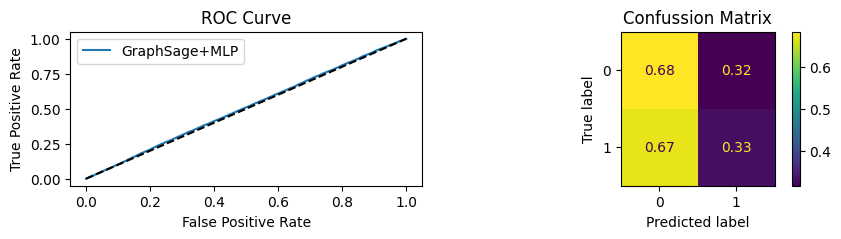

Replacing models:   
with: Best models at GraphSage_epoch_1.pt  link_predictor_epoch_1.pt
Saving Model in Path GraphSage_epoch_1.pt
Saving Model in Path link_predictor_epoch_1.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2: loss: 1.38614
Sensitivity (poss_acc):0.8252 Specificity (negative_acc):0.2117 accuracy:0.5184
Replacing models: GraphSage_epoch_1.pt  link_predictor_epoch_1.pt
with: Best models at GraphSage_epoch_2.pt  link_predictor_epoch_2.pt
Saving Model in Path GraphSage_epoch_2.pt
Saving Model in Path link_predictor_epoch_2.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3: loss: 1.38463
Sensitivity (poss_acc):0.9350 Specificity (negative_acc):0.2309 accuracy:0.5829
Replacing models: GraphSage_epoch_2.pt  link_predictor_epoch_2.pt
with: Best models at GraphSage_epoch_3.pt  link_predictor_epoch_3.pt
Saving Model in Path GraphSage_epoch_3.pt
Saving Model in Path link_predictor_epoch_3.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4: loss: 1.3332
Sensitivity (poss_acc):0.8810 Specificity (negative_acc):0.3632 accuracy:0.6221
Replacing models: GraphSage_epoch_3.pt  link_predictor_epoch_3.pt
with: Best models at GraphSage_epoch_4.pt  link_predictor_epoch_4.pt
Saving Model in Path GraphSage_epoch_4.pt
Saving Model in Path link_predictor_epoch_4.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5: loss: 1.23284
Sensitivity (poss_acc):0.9000 Specificity (negative_acc):0.3776 accuracy:0.6388
Replacing models: GraphSage_epoch_4.pt  link_predictor_epoch_4.pt
with: Best models at GraphSage_epoch_5.pt  link_predictor_epoch_5.pt
Saving Model in Path GraphSage_epoch_5.pt
Saving Model in Path link_predictor_epoch_5.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6: loss: 1.24907
Sensitivity (poss_acc):0.5224 Specificity (negative_acc):0.5986 accuracy:0.5605


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7: loss: 1.28041
Sensitivity (poss_acc):0.8782 Specificity (negative_acc):0.3660 accuracy:0.6221


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8: loss: 1.20592
Sensitivity (poss_acc):0.9635 Specificity (negative_acc):0.3077 accuracy:0.6356


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9: loss: 1.12853
Sensitivity (poss_acc):0.9092 Specificity (negative_acc):0.4707 accuracy:0.6900
Replacing models: GraphSage_epoch_5.pt  link_predictor_epoch_5.pt
with: Best models at GraphSage_epoch_9.pt  link_predictor_epoch_9.pt
Saving Model in Path GraphSage_epoch_9.pt
Saving Model in Path link_predictor_epoch_9.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10: loss: 1.13204
Sensitivity (poss_acc):0.9162 Specificity (negative_acc):0.4552 accuracy:0.6857


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11: loss: 1.08384
Sensitivity (poss_acc):0.6898 Specificity (negative_acc):0.6484 accuracy:0.6691


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12: loss: 1.06029
Sensitivity (poss_acc):0.7078 Specificity (negative_acc):0.6942 accuracy:0.7010
Replacing models: GraphSage_epoch_9.pt  link_predictor_epoch_9.pt
with: Best models at GraphSage_epoch_12.pt  link_predictor_epoch_12.pt
Saving Model in Path GraphSage_epoch_12.pt
Saving Model in Path link_predictor_epoch_12.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13: loss: 1.06227
Sensitivity (poss_acc):0.7683 Specificity (negative_acc):0.6015 accuracy:0.6849


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14: loss: 1.04963
Sensitivity (poss_acc):0.8731 Specificity (negative_acc):0.5512 accuracy:0.7122
Replacing models: GraphSage_epoch_12.pt  link_predictor_epoch_12.pt
with: Best models at GraphSage_epoch_14.pt  link_predictor_epoch_14.pt
Saving Model in Path GraphSage_epoch_14.pt
Saving Model in Path link_predictor_epoch_14.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15: loss: 1.01064
Sensitivity (poss_acc):0.8945 Specificity (negative_acc):0.4840 accuracy:0.6893


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 16: loss: 1.02564
Sensitivity (poss_acc):0.7047 Specificity (negative_acc):0.7023 accuracy:0.7035


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 17: loss: 0.98034
Sensitivity (poss_acc):0.8704 Specificity (negative_acc):0.5577 accuracy:0.7140
Replacing models: GraphSage_epoch_14.pt  link_predictor_epoch_14.pt
with: Best models at GraphSage_epoch_17.pt  link_predictor_epoch_17.pt
Saving Model in Path GraphSage_epoch_17.pt
Saving Model in Path link_predictor_epoch_17.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 18: loss: 0.98538
Sensitivity (poss_acc):0.7756 Specificity (negative_acc):0.6488 accuracy:0.7122


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 19: loss: 0.97591
Sensitivity (poss_acc):0.7789 Specificity (negative_acc):0.6861 accuracy:0.7325
Replacing models: GraphSage_epoch_17.pt  link_predictor_epoch_17.pt
with: Best models at GraphSage_epoch_19.pt  link_predictor_epoch_19.pt
Saving Model in Path GraphSage_epoch_19.pt
Saving Model in Path link_predictor_epoch_19.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20: loss: 0.99183
Youdens  index: 0.6296 Sensitivity: 0.7128 Specificity: 0.7018


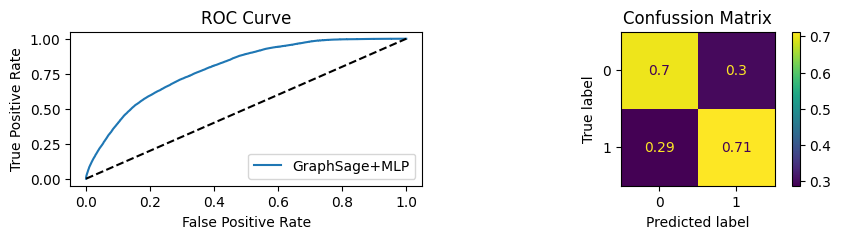

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 21: loss: 0.94824
Sensitivity (poss_acc):0.8119 Specificity (negative_acc):0.6123 accuracy:0.7121


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 22: loss: 0.95164
Sensitivity (poss_acc):0.8740 Specificity (negative_acc):0.5648 accuracy:0.7194


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 23: loss: 0.92309
Sensitivity (poss_acc):0.8093 Specificity (negative_acc):0.6073 accuracy:0.7083


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 24: loss: 0.90591
Sensitivity (poss_acc):0.8679 Specificity (negative_acc):0.5768 accuracy:0.7223


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 25: loss: 0.89268
Sensitivity (poss_acc):0.8058 Specificity (negative_acc):0.6467 accuracy:0.7263


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 26: loss: 0.90408
Sensitivity (poss_acc):0.8594 Specificity (negative_acc):0.5980 accuracy:0.7287


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 27: loss: 0.88659
Sensitivity (poss_acc):0.7914 Specificity (negative_acc):0.6508 accuracy:0.7211


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 28: loss: 0.86054
Sensitivity (poss_acc):0.8014 Specificity (negative_acc):0.6656 accuracy:0.7335
Replacing models: GraphSage_epoch_19.pt  link_predictor_epoch_19.pt
with: Best models at GraphSage_epoch_28.pt  link_predictor_epoch_28.pt
Saving Model in Path GraphSage_epoch_28.pt
Saving Model in Path link_predictor_epoch_28.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 29: loss: 0.8593
Sensitivity (poss_acc):0.8800 Specificity (negative_acc):0.6003 accuracy:0.7401
Replacing models: GraphSage_epoch_28.pt  link_predictor_epoch_28.pt
with: Best models at GraphSage_epoch_29.pt  link_predictor_epoch_29.pt
Saving Model in Path GraphSage_epoch_29.pt
Saving Model in Path link_predictor_epoch_29.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 30: loss: 0.84031
Sensitivity (poss_acc):0.7682 Specificity (negative_acc):0.6855 accuracy:0.7269


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 31: loss: 0.82922
Sensitivity (poss_acc):0.8506 Specificity (negative_acc):0.5955 accuracy:0.7230


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 32: loss: 0.89779
Sensitivity (poss_acc):0.9056 Specificity (negative_acc):0.5731 accuracy:0.7393


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 33: loss: 0.81816
Sensitivity (poss_acc):0.9166 Specificity (negative_acc):0.5448 accuracy:0.7307


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 34: loss: 0.83937
Sensitivity (poss_acc):0.8341 Specificity (negative_acc):0.6407 accuracy:0.7374


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 35: loss: 0.80066
Sensitivity (poss_acc):0.8574 Specificity (negative_acc):0.6354 accuracy:0.7464
Replacing models: GraphSage_epoch_29.pt  link_predictor_epoch_29.pt
with: Best models at GraphSage_epoch_35.pt  link_predictor_epoch_35.pt
Saving Model in Path GraphSage_epoch_35.pt
Saving Model in Path link_predictor_epoch_35.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 36: loss: 0.82452
Sensitivity (poss_acc):0.8161 Specificity (negative_acc):0.6823 accuracy:0.7492
Replacing models: GraphSage_epoch_35.pt  link_predictor_epoch_35.pt
with: Best models at GraphSage_epoch_36.pt  link_predictor_epoch_36.pt
Saving Model in Path GraphSage_epoch_36.pt
Saving Model in Path link_predictor_epoch_36.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 37: loss: 0.795
Sensitivity (poss_acc):0.8560 Specificity (negative_acc):0.6546 accuracy:0.7553
Replacing models: GraphSage_epoch_36.pt  link_predictor_epoch_36.pt
with: Best models at GraphSage_epoch_37.pt  link_predictor_epoch_37.pt
Saving Model in Path GraphSage_epoch_37.pt
Saving Model in Path link_predictor_epoch_37.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 38: loss: 0.775
Sensitivity (poss_acc):0.7666 Specificity (negative_acc):0.7051 accuracy:0.7358


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 39: loss: 0.77688
Sensitivity (poss_acc):0.8864 Specificity (negative_acc):0.5919 accuracy:0.7391


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 40: loss: 0.77014
Youdens  index: 0.5298 Sensitivity: 0.825 Specificity: 0.6481


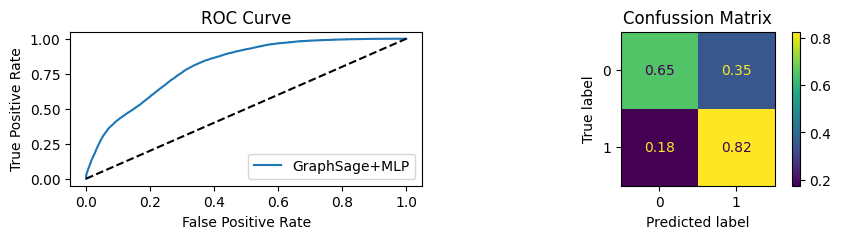

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 41: loss: 0.77564
Sensitivity (poss_acc):0.8507 Specificity (negative_acc):0.6416 accuracy:0.7462


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 42: loss: 0.76536
Sensitivity (poss_acc):0.8773 Specificity (negative_acc):0.6335 accuracy:0.7554
Replacing models: GraphSage_epoch_37.pt  link_predictor_epoch_37.pt
with: Best models at GraphSage_epoch_42.pt  link_predictor_epoch_42.pt
Saving Model in Path GraphSage_epoch_42.pt
Saving Model in Path link_predictor_epoch_42.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 43: loss: 0.75756
Sensitivity (poss_acc):0.8017 Specificity (negative_acc):0.6687 accuracy:0.7352


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 44: loss: 0.77873
Sensitivity (poss_acc):0.8070 Specificity (negative_acc):0.7004 accuracy:0.7537


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 45: loss: 0.75666
Sensitivity (poss_acc):0.8784 Specificity (negative_acc):0.6495 accuracy:0.7639
Replacing models: GraphSage_epoch_42.pt  link_predictor_epoch_42.pt
with: Best models at GraphSage_epoch_45.pt  link_predictor_epoch_45.pt
Saving Model in Path GraphSage_epoch_45.pt
Saving Model in Path link_predictor_epoch_45.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 46: loss: 0.73604
Sensitivity (poss_acc):0.8434 Specificity (negative_acc):0.6621 accuracy:0.7527


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 47: loss: 0.71601
Sensitivity (poss_acc):0.8178 Specificity (negative_acc):0.6714 accuracy:0.7446


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 48: loss: 0.73447
Sensitivity (poss_acc):0.8929 Specificity (negative_acc):0.6169 accuracy:0.7549


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 49: loss: 0.70766
Sensitivity (poss_acc):0.8879 Specificity (negative_acc):0.6044 accuracy:0.7461


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 50: loss: 0.721
Sensitivity (poss_acc):0.7702 Specificity (negative_acc):0.7172 accuracy:0.7437


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 51: loss: 0.70365
Sensitivity (poss_acc):0.8941 Specificity (negative_acc):0.5911 accuracy:0.7426


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 52: loss: 0.71855
Sensitivity (poss_acc):0.8371 Specificity (negative_acc):0.6921 accuracy:0.7646
Replacing models: GraphSage_epoch_45.pt  link_predictor_epoch_45.pt
with: Best models at GraphSage_epoch_52.pt  link_predictor_epoch_52.pt
Saving Model in Path GraphSage_epoch_52.pt
Saving Model in Path link_predictor_epoch_52.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 53: loss: 0.70317
Sensitivity (poss_acc):0.8851 Specificity (negative_acc):0.6400 accuracy:0.7626


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 54: loss: 0.68315
Sensitivity (poss_acc):0.8620 Specificity (negative_acc):0.6639 accuracy:0.7629


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 55: loss: 0.68344
Sensitivity (poss_acc):0.9168 Specificity (negative_acc):0.6041 accuracy:0.7605


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 56: loss: 0.72247
Sensitivity (poss_acc):0.8332 Specificity (negative_acc):0.6505 accuracy:0.7419


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 57: loss: 0.68305
Sensitivity (poss_acc):0.7903 Specificity (negative_acc):0.6858 accuracy:0.7380


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 58: loss: 0.72189
Sensitivity (poss_acc):0.8622 Specificity (negative_acc):0.6615 accuracy:0.7618


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 59: loss: 0.71029
Sensitivity (poss_acc):0.8834 Specificity (negative_acc):0.6440 accuracy:0.7637


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 60: loss: 0.68376
Youdens  index: 0.6426 Sensitivity: 0.7956 Specificity: 0.7022


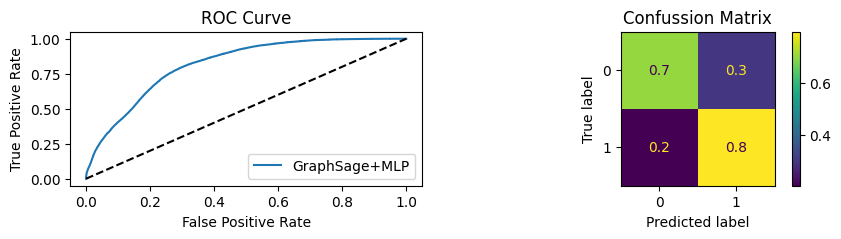

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 61: loss: 0.66578
Sensitivity (poss_acc):0.8348 Specificity (negative_acc):0.7032 accuracy:0.7690
Replacing models: GraphSage_epoch_52.pt  link_predictor_epoch_52.pt
with: Best models at GraphSage_epoch_61.pt  link_predictor_epoch_61.pt
Saving Model in Path GraphSage_epoch_61.pt
Saving Model in Path link_predictor_epoch_61.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 62: loss: 0.6673
Sensitivity (poss_acc):0.8208 Specificity (negative_acc):0.7111 accuracy:0.7659


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 63: loss: 0.68062
Sensitivity (poss_acc):0.8707 Specificity (negative_acc):0.6446 accuracy:0.7576


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 64: loss: 0.6795
Sensitivity (poss_acc):0.8385 Specificity (negative_acc):0.6963 accuracy:0.7674


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 65: loss: 0.66361
Sensitivity (poss_acc):0.8480 Specificity (negative_acc):0.6889 accuracy:0.7684


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 66: loss: 0.62076
Sensitivity (poss_acc):0.8800 Specificity (negative_acc):0.6549 accuracy:0.7674


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 67: loss: 0.65321
Sensitivity (poss_acc):0.8725 Specificity (negative_acc):0.6989 accuracy:0.7857
Replacing models: GraphSage_epoch_61.pt  link_predictor_epoch_61.pt
with: Best models at GraphSage_epoch_67.pt  link_predictor_epoch_67.pt
Saving Model in Path GraphSage_epoch_67.pt
Saving Model in Path link_predictor_epoch_67.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 68: loss: 0.65814
Sensitivity (poss_acc):0.8510 Specificity (negative_acc):0.6696 accuracy:0.7603


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 69: loss: 0.61733
Sensitivity (poss_acc):0.8883 Specificity (negative_acc):0.6437 accuracy:0.7660


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 70: loss: 0.62729
Sensitivity (poss_acc):0.8375 Specificity (negative_acc):0.6697 accuracy:0.7536


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 71: loss: 0.63786
Sensitivity (poss_acc):0.8540 Specificity (negative_acc):0.6948 accuracy:0.7744


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 72: loss: 0.61542
Sensitivity (poss_acc):0.8660 Specificity (negative_acc):0.6844 accuracy:0.7752


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 73: loss: 0.63899
Sensitivity (poss_acc):0.9172 Specificity (negative_acc):0.6451 accuracy:0.7812


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 74: loss: 0.62225
Sensitivity (poss_acc):0.9224 Specificity (negative_acc):0.6045 accuracy:0.7634


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 75: loss: 0.61122
Sensitivity (poss_acc):0.8573 Specificity (negative_acc):0.6775 accuracy:0.7674


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 76: loss: 0.63183
Sensitivity (poss_acc):0.8417 Specificity (negative_acc):0.6718 accuracy:0.7568


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 77: loss: 0.60156
Sensitivity (poss_acc):0.8331 Specificity (negative_acc):0.7251 accuracy:0.7791


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 78: loss: 0.60803
Sensitivity (poss_acc):0.8507 Specificity (negative_acc):0.6427 accuracy:0.7467


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 79: loss: 0.62981
Sensitivity (poss_acc):0.8813 Specificity (negative_acc):0.6210 accuracy:0.7512


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 80: loss: 0.62121
Youdens  index: 0.5663 Sensitivity: 0.8471 Specificity: 0.6592


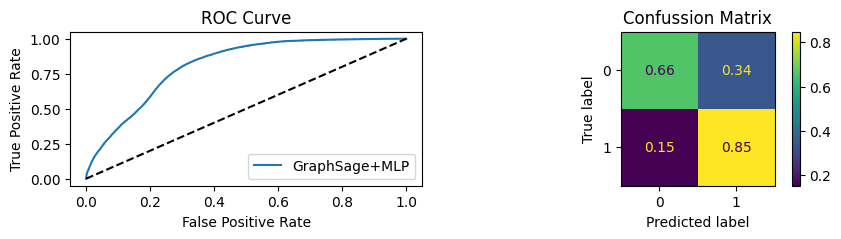

Replacing models: GraphSage_epoch_67.pt  link_predictor_epoch_67.pt
with: Best models at GraphSage_epoch_80.pt  link_predictor_epoch_80.pt
Saving Model in Path GraphSage_epoch_80.pt
Saving Model in Path link_predictor_epoch_80.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 81: loss: 0.60267
Sensitivity (poss_acc):0.9296 Specificity (negative_acc):0.6217 accuracy:0.7756


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 82: loss: 0.59262
Sensitivity (poss_acc):0.9133 Specificity (negative_acc):0.6490 accuracy:0.7811


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 83: loss: 0.57688
Sensitivity (poss_acc):0.8874 Specificity (negative_acc):0.6519 accuracy:0.7697


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 84: loss: 0.61293
Sensitivity (poss_acc):0.9245 Specificity (negative_acc):0.6087 accuracy:0.7666


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 85: loss: 0.60371
Sensitivity (poss_acc):0.8326 Specificity (negative_acc):0.7372 accuracy:0.7849


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 86: loss: 0.58238
Sensitivity (poss_acc):0.8584 Specificity (negative_acc):0.7173 accuracy:0.7879


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 87: loss: 0.57882
Sensitivity (poss_acc):0.8350 Specificity (negative_acc):0.7388 accuracy:0.7869


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 88: loss: 0.58094
Sensitivity (poss_acc):0.9041 Specificity (negative_acc):0.6514 accuracy:0.7778


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 89: loss: 0.57736
Sensitivity (poss_acc):0.9035 Specificity (negative_acc):0.6471 accuracy:0.7753


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 90: loss: 0.59027
Sensitivity (poss_acc):0.8923 Specificity (negative_acc):0.6594 accuracy:0.7759


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 91: loss: 0.56539
Sensitivity (poss_acc):0.8236 Specificity (negative_acc):0.7368 accuracy:0.7802


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 92: loss: 0.5552
Sensitivity (poss_acc):0.8738 Specificity (negative_acc):0.6527 accuracy:0.7633


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 93: loss: 0.57432
Sensitivity (poss_acc):0.9030 Specificity (negative_acc):0.6750 accuracy:0.7890


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 94: loss: 0.56306
Sensitivity (poss_acc):0.9061 Specificity (negative_acc):0.6587 accuracy:0.7824


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 95: loss: 0.55674
Sensitivity (poss_acc):0.9025 Specificity (negative_acc):0.6688 accuracy:0.7857


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 96: loss: 0.55312
Sensitivity (poss_acc):0.8650 Specificity (negative_acc):0.7189 accuracy:0.7920


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 97: loss: 0.54806
Sensitivity (poss_acc):0.9043 Specificity (negative_acc):0.6350 accuracy:0.7697


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 98: loss: 0.54841
Sensitivity (poss_acc):0.8942 Specificity (negative_acc):0.6665 accuracy:0.7803


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 99: loss: 0.55615
Sensitivity (poss_acc):0.9013 Specificity (negative_acc):0.6701 accuracy:0.7857


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 100: loss: 0.54454
Youdens  index: 0.4448 Sensitivity: 0.8937 Specificity: 0.6138


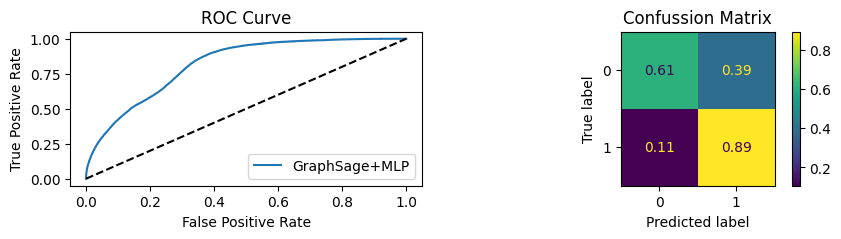

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 101: loss: 0.54446
Sensitivity (poss_acc):0.8894 Specificity (negative_acc):0.6551 accuracy:0.7723


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 102: loss: 0.5723
Sensitivity (poss_acc):0.8506 Specificity (negative_acc):0.6718 accuracy:0.7612


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 103: loss: 0.56733
Sensitivity (poss_acc):0.8526 Specificity (negative_acc):0.6583 accuracy:0.7554


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 104: loss: 0.58279
Sensitivity (poss_acc):0.8929 Specificity (negative_acc):0.6595 accuracy:0.7762


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 105: loss: 0.55634
Sensitivity (poss_acc):0.8726 Specificity (negative_acc):0.7020 accuracy:0.7873


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 106: loss: 0.52631
Sensitivity (poss_acc):0.8754 Specificity (negative_acc):0.6962 accuracy:0.7858


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 107: loss: 0.53896
Sensitivity (poss_acc):0.9066 Specificity (negative_acc):0.6293 accuracy:0.7680


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 108: loss: 0.54728
Sensitivity (poss_acc):0.8757 Specificity (negative_acc):0.6988 accuracy:0.7872


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 109: loss: 0.54289
Sensitivity (poss_acc):0.8233 Specificity (negative_acc):0.7388 accuracy:0.7811


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 110: loss: 0.57868
Sensitivity (poss_acc):0.8988 Specificity (negative_acc):0.6629 accuracy:0.7808


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 111: loss: 0.54878
Sensitivity (poss_acc):0.8878 Specificity (negative_acc):0.6634 accuracy:0.7756


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 112: loss: 0.52526
Sensitivity (poss_acc):0.8668 Specificity (negative_acc):0.6882 accuracy:0.7775


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 113: loss: 0.50896
Sensitivity (poss_acc):0.8924 Specificity (negative_acc):0.6953 accuracy:0.7939
Replacing models: GraphSage_epoch_80.pt  link_predictor_epoch_80.pt
with: Best models at GraphSage_epoch_113.pt  link_predictor_epoch_113.pt
Saving Model in Path GraphSage_epoch_113.pt
Saving Model in Path link_predictor_epoch_113.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 114: loss: 0.50759
Sensitivity (poss_acc):0.8995 Specificity (negative_acc):0.6727 accuracy:0.7861


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 115: loss: 0.50268
Sensitivity (poss_acc):0.8969 Specificity (negative_acc):0.6606 accuracy:0.7788


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 116: loss: 0.50792
Sensitivity (poss_acc):0.9244 Specificity (negative_acc):0.6078 accuracy:0.7661


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 117: loss: 0.52405
Sensitivity (poss_acc):0.9112 Specificity (negative_acc):0.6921 accuracy:0.8017
Replacing models: GraphSage_epoch_113.pt  link_predictor_epoch_113.pt
with: Best models at GraphSage_epoch_117.pt  link_predictor_epoch_117.pt
Saving Model in Path GraphSage_epoch_117.pt
Saving Model in Path link_predictor_epoch_117.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 118: loss: 0.51385
Sensitivity (poss_acc):0.9144 Specificity (negative_acc):0.6564 accuracy:0.7854


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 119: loss: 0.50277
Sensitivity (poss_acc):0.7894 Specificity (negative_acc):0.7720 accuracy:0.7807


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 120: loss: 0.55554
Youdens  index: 0.8903 Sensitivity: 0.7731 Specificity: 0.7513


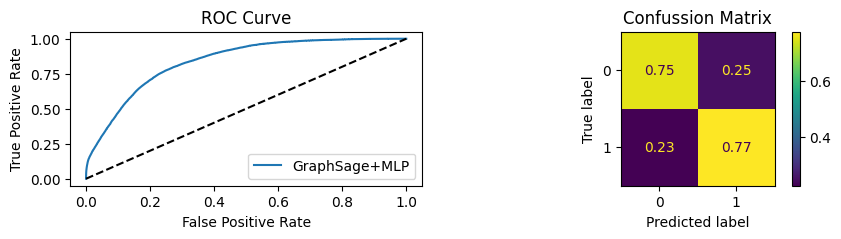

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 121: loss: 0.52758
Sensitivity (poss_acc):0.8491 Specificity (negative_acc):0.7034 accuracy:0.7762


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 122: loss: 0.51773
Sensitivity (poss_acc):0.8961 Specificity (negative_acc):0.6889 accuracy:0.7925


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 123: loss: 0.5199
Sensitivity (poss_acc):0.9011 Specificity (negative_acc):0.6201 accuracy:0.7606


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 124: loss: 0.49275
Sensitivity (poss_acc):0.9145 Specificity (negative_acc):0.6465 accuracy:0.7805


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 125: loss: 0.48386
Sensitivity (poss_acc):0.9110 Specificity (negative_acc):0.6463 accuracy:0.7786


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 126: loss: 0.48924
Sensitivity (poss_acc):0.8364 Specificity (negative_acc):0.7269 accuracy:0.7817


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 127: loss: 0.51036
Sensitivity (poss_acc):0.8763 Specificity (negative_acc):0.7330 accuracy:0.8047
Replacing models: GraphSage_epoch_117.pt  link_predictor_epoch_117.pt
with: Best models at GraphSage_epoch_127.pt  link_predictor_epoch_127.pt
Saving Model in Path GraphSage_epoch_127.pt
Saving Model in Path link_predictor_epoch_127.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 128: loss: 0.49851
Sensitivity (poss_acc):0.8669 Specificity (negative_acc):0.7206 accuracy:0.7937


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 129: loss: 0.50085
Sensitivity (poss_acc):0.9474 Specificity (negative_acc):0.6183 accuracy:0.7829


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 130: loss: 0.54889
Sensitivity (poss_acc):0.6257 Specificity (negative_acc):0.8309 accuracy:0.7283


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 131: loss: 0.55055
Sensitivity (poss_acc):0.8653 Specificity (negative_acc):0.6874 accuracy:0.7763


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 132: loss: 0.51206
Sensitivity (poss_acc):0.9042 Specificity (negative_acc):0.6420 accuracy:0.7731


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 133: loss: 0.51192
Sensitivity (poss_acc):0.8775 Specificity (negative_acc):0.6130 accuracy:0.7452


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 134: loss: 0.50242
Sensitivity (poss_acc):0.8995 Specificity (negative_acc):0.6712 accuracy:0.7854


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 135: loss: 0.48485
Sensitivity (poss_acc):0.9119 Specificity (negative_acc):0.6743 accuracy:0.7931


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 136: loss: 0.48699
Sensitivity (poss_acc):0.8436 Specificity (negative_acc):0.7155 accuracy:0.7796


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 137: loss: 0.49194
Sensitivity (poss_acc):0.8512 Specificity (negative_acc):0.6830 accuracy:0.7671


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 138: loss: 0.50101
Sensitivity (poss_acc):0.9332 Specificity (negative_acc):0.6543 accuracy:0.7938


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 139: loss: 0.47573
Sensitivity (poss_acc):0.8989 Specificity (negative_acc):0.6814 accuracy:0.7901


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 140: loss: 0.49843
Youdens  index: 0.8106 Sensitivity: 0.7878 Specificity: 0.7682


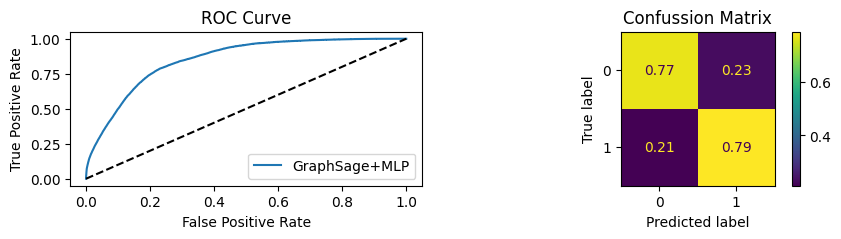

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 141: loss: 0.49341
Sensitivity (poss_acc):0.9493 Specificity (negative_acc):0.6303 accuracy:0.7898


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 142: loss: 0.49255
Sensitivity (poss_acc):0.9033 Specificity (negative_acc):0.6476 accuracy:0.7754


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 143: loss: 0.50336
Sensitivity (poss_acc):0.9380 Specificity (negative_acc):0.5859 accuracy:0.7620


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 144: loss: 0.50648
Sensitivity (poss_acc):0.8858 Specificity (negative_acc):0.7136 accuracy:0.7997


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 145: loss: 0.47623
Sensitivity (poss_acc):0.9039 Specificity (negative_acc):0.6729 accuracy:0.7884


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 146: loss: 0.4612
Sensitivity (poss_acc):0.8685 Specificity (negative_acc):0.7316 accuracy:0.8000


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 147: loss: 0.4581
Sensitivity (poss_acc):0.9303 Specificity (negative_acc):0.6462 accuracy:0.7883


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 148: loss: 0.48994
Sensitivity (poss_acc):0.8567 Specificity (negative_acc):0.7341 accuracy:0.7954


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 149: loss: 0.48878
Sensitivity (poss_acc):0.9125 Specificity (negative_acc):0.6570 accuracy:0.7847


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 150: loss: 0.53287
Sensitivity (poss_acc):0.8979 Specificity (negative_acc):0.6948 accuracy:0.7963


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 151: loss: 0.49147
Sensitivity (poss_acc):0.9002 Specificity (negative_acc):0.6850 accuracy:0.7926


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 152: loss: 0.46707
Sensitivity (poss_acc):0.9427 Specificity (negative_acc):0.6313 accuracy:0.7870


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 153: loss: 0.48187
Sensitivity (poss_acc):0.9323 Specificity (negative_acc):0.6508 accuracy:0.7916


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 154: loss: 0.47412
Sensitivity (poss_acc):0.9231 Specificity (negative_acc):0.6634 accuracy:0.7933


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 155: loss: 0.46019
Sensitivity (poss_acc):0.9138 Specificity (negative_acc):0.6684 accuracy:0.7911


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 156: loss: 0.45743
Sensitivity (poss_acc):0.8920 Specificity (negative_acc):0.6928 accuracy:0.7924


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 157: loss: 0.46888
Sensitivity (poss_acc):0.9020 Specificity (negative_acc):0.7071 accuracy:0.8045


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 158: loss: 0.45439
Sensitivity (poss_acc):0.9209 Specificity (negative_acc):0.6748 accuracy:0.7979


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 159: loss: 0.45289
Sensitivity (poss_acc):0.8891 Specificity (negative_acc):0.6905 accuracy:0.7898


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 160: loss: 0.44807
Youdens  index: 0.8163 Sensitivity: 0.8043 Specificity: 0.7319


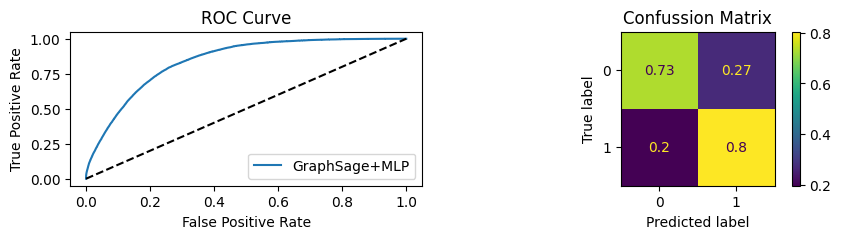

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 161: loss: 0.49089
Sensitivity (poss_acc):0.9219 Specificity (negative_acc):0.6560 accuracy:0.7890


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 162: loss: 0.47265
Sensitivity (poss_acc):0.9236 Specificity (negative_acc):0.6515 accuracy:0.7875


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 163: loss: 0.44
Sensitivity (poss_acc):0.9045 Specificity (negative_acc):0.6998 accuracy:0.8021


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 164: loss: 0.44266
Sensitivity (poss_acc):0.8685 Specificity (negative_acc):0.7099 accuracy:0.7892


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 165: loss: 0.45557
Sensitivity (poss_acc):0.9253 Specificity (negative_acc):0.6358 accuracy:0.7805


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 166: loss: 0.44287
Sensitivity (poss_acc):0.8703 Specificity (negative_acc):0.7072 accuracy:0.7888


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 167: loss: 0.48216
Sensitivity (poss_acc):0.9269 Specificity (negative_acc):0.6661 accuracy:0.7965


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 168: loss: 0.47142
Sensitivity (poss_acc):0.9055 Specificity (negative_acc):0.7056 accuracy:0.8055
Replacing models: GraphSage_epoch_127.pt  link_predictor_epoch_127.pt
with: Best models at GraphSage_epoch_168.pt  link_predictor_epoch_168.pt
Saving Model in Path GraphSage_epoch_168.pt
Saving Model in Path link_predictor_epoch_168.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 169: loss: 0.43165
Sensitivity (poss_acc):0.9116 Specificity (negative_acc):0.6951 accuracy:0.8033


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 170: loss: 0.47262
Sensitivity (poss_acc):0.8697 Specificity (negative_acc):0.6667 accuracy:0.7682


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 171: loss: 0.61125
Sensitivity (poss_acc):0.9161 Specificity (negative_acc):0.6978 accuracy:0.8070
Replacing models: GraphSage_epoch_168.pt  link_predictor_epoch_168.pt
with: Best models at GraphSage_epoch_171.pt  link_predictor_epoch_171.pt
Saving Model in Path GraphSage_epoch_171.pt
Saving Model in Path link_predictor_epoch_171.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 172: loss: 0.46705
Sensitivity (poss_acc):0.9193 Specificity (negative_acc):0.6860 accuracy:0.8027


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 173: loss: 0.44765
Sensitivity (poss_acc):0.9180 Specificity (negative_acc):0.6723 accuracy:0.7951


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 174: loss: 0.43044
Sensitivity (poss_acc):0.9091 Specificity (negative_acc):0.6971 accuracy:0.8031


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 175: loss: 0.45681
Sensitivity (poss_acc):0.9198 Specificity (negative_acc):0.6693 accuracy:0.7945


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 176: loss: 0.466
Sensitivity (poss_acc):0.8678 Specificity (negative_acc):0.6825 accuracy:0.7752


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 177: loss: 0.54062
Sensitivity (poss_acc):0.9125 Specificity (negative_acc):0.6593 accuracy:0.7859


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 178: loss: 0.48161
Sensitivity (poss_acc):0.9141 Specificity (negative_acc):0.6930 accuracy:0.8036


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 179: loss: 0.45612
Sensitivity (poss_acc):0.9156 Specificity (negative_acc):0.6663 accuracy:0.7910


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 180: loss: 0.43715
Youdens  index: 0.8723 Sensitivity: 0.8152 Specificity: 0.728


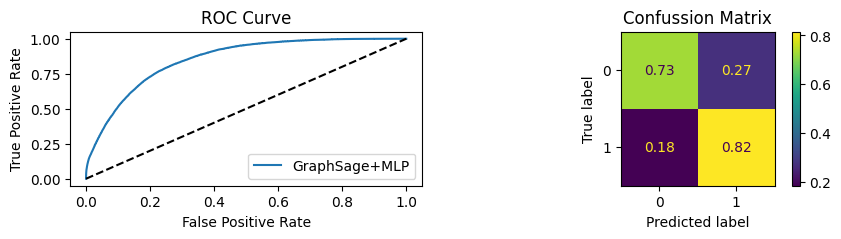

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 181: loss: 0.42755
Sensitivity (poss_acc):0.9248 Specificity (negative_acc):0.6706 accuracy:0.7977


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 182: loss: 0.41749
Sensitivity (poss_acc):0.9439 Specificity (negative_acc):0.6517 accuracy:0.7978


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 183: loss: 0.42708
Sensitivity (poss_acc):0.8720 Specificity (negative_acc):0.7587 accuracy:0.8154
Replacing models: GraphSage_epoch_171.pt  link_predictor_epoch_171.pt
with: Best models at GraphSage_epoch_183.pt  link_predictor_epoch_183.pt
Saving Model in Path GraphSage_epoch_183.pt
Saving Model in Path link_predictor_epoch_183.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 184: loss: 0.41298
Sensitivity (poss_acc):0.9118 Specificity (negative_acc):0.7048 accuracy:0.8083


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 185: loss: 0.41202
Sensitivity (poss_acc):0.9100 Specificity (negative_acc):0.6900 accuracy:0.8000


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 186: loss: 0.40708
Sensitivity (poss_acc):0.9198 Specificity (negative_acc):0.6820 accuracy:0.8009


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 187: loss: 0.40626
Sensitivity (poss_acc):0.8890 Specificity (negative_acc):0.7266 accuracy:0.8078


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 188: loss: 0.40534
Sensitivity (poss_acc):0.9348 Specificity (negative_acc):0.6586 accuracy:0.7967


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 189: loss: 0.4076
Sensitivity (poss_acc):0.9150 Specificity (negative_acc):0.7113 accuracy:0.8132


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 190: loss: 0.45307
Sensitivity (poss_acc):0.9209 Specificity (negative_acc):0.6623 accuracy:0.7916


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 191: loss: 0.44397
Sensitivity (poss_acc):0.9187 Specificity (negative_acc):0.6886 accuracy:0.8036


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 192: loss: 0.42787
Sensitivity (poss_acc):0.9268 Specificity (negative_acc):0.6716 accuracy:0.7992


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 193: loss: 0.42432
Sensitivity (poss_acc):0.9124 Specificity (negative_acc):0.7081 accuracy:0.8102


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 194: loss: 0.41286
Sensitivity (poss_acc):0.9431 Specificity (negative_acc):0.6466 accuracy:0.7949


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 195: loss: 0.3983
Sensitivity (poss_acc):0.8974 Specificity (negative_acc):0.7192 accuracy:0.8083


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 196: loss: 0.4047
Sensitivity (poss_acc):0.9017 Specificity (negative_acc):0.7000 accuracy:0.8008


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 197: loss: 0.41938
Sensitivity (poss_acc):0.9122 Specificity (negative_acc):0.7020 accuracy:0.8071


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 198: loss: 0.41011
Sensitivity (poss_acc):0.8877 Specificity (negative_acc):0.6849 accuracy:0.7863


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 199: loss: 0.40851
Sensitivity (poss_acc):0.9508 Specificity (negative_acc):0.6040 accuracy:0.7774


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 200: loss: 0.40208
Youdens  index: 0.8050 Sensitivity: 0.8685 Specificity: 0.6462


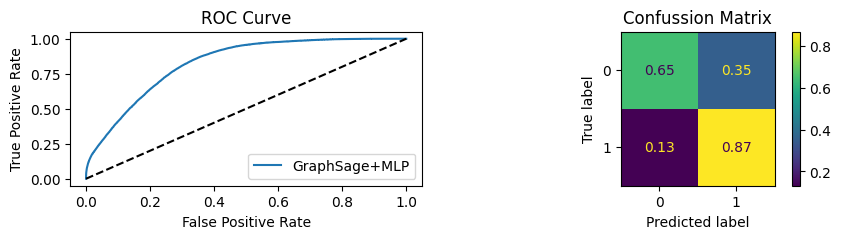

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 201: loss: 0.4103
Sensitivity (poss_acc):0.9197 Specificity (negative_acc):0.6839 accuracy:0.8018


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 202: loss: 0.40747
Sensitivity (poss_acc):0.8880 Specificity (negative_acc):0.7392 accuracy:0.8136


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 203: loss: 0.41031
Sensitivity (poss_acc):0.9370 Specificity (negative_acc):0.6643 accuracy:0.8007


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 204: loss: 0.43305
Sensitivity (poss_acc):0.8786 Specificity (negative_acc):0.7546 accuracy:0.8166
Replacing models: GraphSage_epoch_183.pt  link_predictor_epoch_183.pt
with: Best models at GraphSage_epoch_204.pt  link_predictor_epoch_204.pt
Saving Model in Path GraphSage_epoch_204.pt
Saving Model in Path link_predictor_epoch_204.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 205: loss: 0.42921
Sensitivity (poss_acc):0.9255 Specificity (negative_acc):0.6437 accuracy:0.7846


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 206: loss: 0.40325
Sensitivity (poss_acc):0.8794 Specificity (negative_acc):0.7583 accuracy:0.8188
Replacing models: GraphSage_epoch_204.pt  link_predictor_epoch_204.pt
with: Best models at GraphSage_epoch_206.pt  link_predictor_epoch_206.pt
Saving Model in Path GraphSage_epoch_206.pt
Saving Model in Path link_predictor_epoch_206.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 207: loss: 0.42156
Sensitivity (poss_acc):0.9212 Specificity (negative_acc):0.6752 accuracy:0.7982


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 208: loss: 0.41784
Sensitivity (poss_acc):0.9274 Specificity (negative_acc):0.6669 accuracy:0.7972


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 209: loss: 0.40038
Sensitivity (poss_acc):0.9144 Specificity (negative_acc):0.7032 accuracy:0.8088


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 210: loss: 0.37098
Sensitivity (poss_acc):0.9144 Specificity (negative_acc):0.6935 accuracy:0.8040


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 211: loss: 0.36849
Sensitivity (poss_acc):0.9085 Specificity (negative_acc):0.6990 accuracy:0.8037


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 212: loss: 0.38473
Sensitivity (poss_acc):0.9147 Specificity (negative_acc):0.7057 accuracy:0.8102


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 213: loss: 0.37492
Sensitivity (poss_acc):0.9260 Specificity (negative_acc):0.6797 accuracy:0.8029


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 214: loss: 0.3749
Sensitivity (poss_acc):0.9214 Specificity (negative_acc):0.6857 accuracy:0.8036


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 215: loss: 0.39814
Sensitivity (poss_acc):0.9321 Specificity (negative_acc):0.6463 accuracy:0.7892


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 216: loss: 0.459
Sensitivity (poss_acc):0.9046 Specificity (negative_acc):0.6838 accuracy:0.7942


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 217: loss: 0.45932
Sensitivity (poss_acc):0.9157 Specificity (negative_acc):0.7072 accuracy:0.8115


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 218: loss: 0.41404
Sensitivity (poss_acc):0.9352 Specificity (negative_acc):0.6760 accuracy:0.8056


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 219: loss: 0.39108
Sensitivity (poss_acc):0.8974 Specificity (negative_acc):0.7331 accuracy:0.8152


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 220: loss: 0.37651
Youdens  index: 0.7470 Sensitivity: 0.8334 Specificity: 0.6935


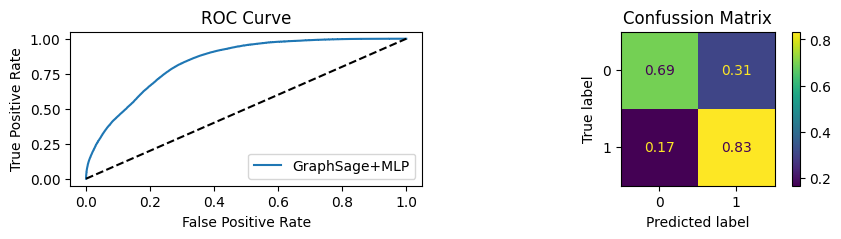

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 221: loss: 0.37296
Sensitivity (poss_acc):0.9149 Specificity (negative_acc):0.6996 accuracy:0.8072


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 222: loss: 0.36198
Sensitivity (poss_acc):0.8977 Specificity (negative_acc):0.7271 accuracy:0.8124


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 223: loss: 0.36658
Sensitivity (poss_acc):0.9045 Specificity (negative_acc):0.7249 accuracy:0.8147


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 224: loss: 0.40081
Sensitivity (poss_acc):0.9213 Specificity (negative_acc):0.6180 accuracy:0.7697


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 225: loss: 0.40396
Sensitivity (poss_acc):0.8988 Specificity (negative_acc):0.7054 accuracy:0.8021


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 226: loss: 0.37393
Sensitivity (poss_acc):0.9002 Specificity (negative_acc):0.7243 accuracy:0.8123


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 227: loss: 0.36643
Sensitivity (poss_acc):0.9167 Specificity (negative_acc):0.7135 accuracy:0.8151


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 228: loss: 0.35272
Sensitivity (poss_acc):0.9018 Specificity (negative_acc):0.6904 accuracy:0.7961


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 229: loss: 0.36281
Sensitivity (poss_acc):0.9305 Specificity (negative_acc):0.6779 accuracy:0.8042


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 230: loss: 0.38086
Sensitivity (poss_acc):0.9119 Specificity (negative_acc):0.7000 accuracy:0.8060


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 231: loss: 0.37236
Sensitivity (poss_acc):0.9165 Specificity (negative_acc):0.7024 accuracy:0.8095


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 232: loss: 0.3733
Sensitivity (poss_acc):0.9305 Specificity (negative_acc):0.6702 accuracy:0.8004


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 233: loss: 0.37444
Sensitivity (poss_acc):0.8984 Specificity (negative_acc):0.6952 accuracy:0.7968


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 234: loss: 0.35352
Sensitivity (poss_acc):0.9126 Specificity (negative_acc):0.6985 accuracy:0.8056


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 235: loss: 0.35052
Sensitivity (poss_acc):0.9115 Specificity (negative_acc):0.7056 accuracy:0.8085


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 236: loss: 0.35984
Sensitivity (poss_acc):0.9219 Specificity (negative_acc):0.7035 accuracy:0.8127


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 237: loss: 0.39235
Sensitivity (poss_acc):0.9239 Specificity (negative_acc):0.6965 accuracy:0.8102


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 238: loss: 0.38771
Sensitivity (poss_acc):0.8825 Specificity (negative_acc):0.7139 accuracy:0.7982


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 239: loss: 0.36623
Sensitivity (poss_acc):0.9317 Specificity (negative_acc):0.6673 accuracy:0.7995


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 240: loss: 0.35054
Youdens  index: 0.7685 Sensitivity: 0.8625 Specificity: 0.6838


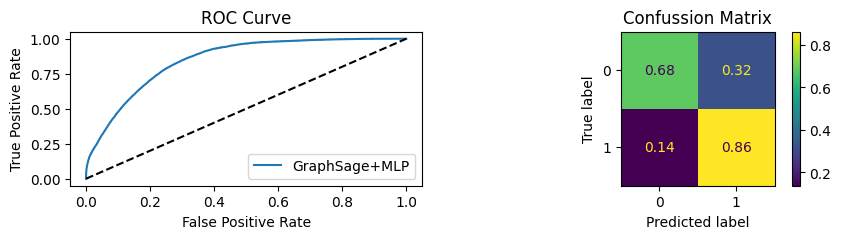

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 241: loss: 0.34954
Sensitivity (poss_acc):0.8987 Specificity (negative_acc):0.7206 accuracy:0.8096


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 242: loss: 0.33929
Sensitivity (poss_acc):0.9120 Specificity (negative_acc):0.7079 accuracy:0.8100


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 243: loss: 0.34533
Sensitivity (poss_acc):0.9267 Specificity (negative_acc):0.7034 accuracy:0.8151


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 244: loss: 0.41143
Sensitivity (poss_acc):0.8742 Specificity (negative_acc):0.7312 accuracy:0.8027


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 245: loss: 0.40834
Sensitivity (poss_acc):0.9291 Specificity (negative_acc):0.6405 accuracy:0.7848


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 246: loss: 0.39436
Sensitivity (poss_acc):0.9190 Specificity (negative_acc):0.6853 accuracy:0.8022


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 247: loss: 0.3475
Sensitivity (poss_acc):0.9343 Specificity (negative_acc):0.6675 accuracy:0.8009


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 248: loss: 0.35281
Sensitivity (poss_acc):0.9211 Specificity (negative_acc):0.6328 accuracy:0.7769


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 249: loss: 0.34568
Sensitivity (poss_acc):0.9172 Specificity (negative_acc):0.7051 accuracy:0.8112


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 250: loss: 0.33825
Sensitivity (poss_acc):0.9178 Specificity (negative_acc):0.6890 accuracy:0.8034


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 251: loss: 0.33479
Sensitivity (poss_acc):0.9357 Specificity (negative_acc):0.6899 accuracy:0.8128


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 252: loss: 0.32778
Sensitivity (poss_acc):0.9049 Specificity (negative_acc):0.7105 accuracy:0.8077


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 253: loss: 0.32766
Sensitivity (poss_acc):0.9207 Specificity (negative_acc):0.6917 accuracy:0.8062


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 254: loss: 0.32788
Sensitivity (poss_acc):0.9353 Specificity (negative_acc):0.6604 accuracy:0.7979


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 255: loss: 0.35386
Sensitivity (poss_acc):0.9138 Specificity (negative_acc):0.7067 accuracy:0.8103


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 256: loss: 0.33551
Sensitivity (poss_acc):0.9296 Specificity (negative_acc):0.6746 accuracy:0.8021


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 257: loss: 0.34903
Sensitivity (poss_acc):0.9326 Specificity (negative_acc):0.6740 accuracy:0.8033


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 258: loss: 0.34495
Sensitivity (poss_acc):0.9302 Specificity (negative_acc):0.6925 accuracy:0.8113


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 259: loss: 0.33097
Sensitivity (poss_acc):0.9193 Specificity (negative_acc):0.6901 accuracy:0.8047


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 260: loss: 0.32369
Youdens  index: 0.8636 Sensitivity: 0.8352 Specificity: 0.7301


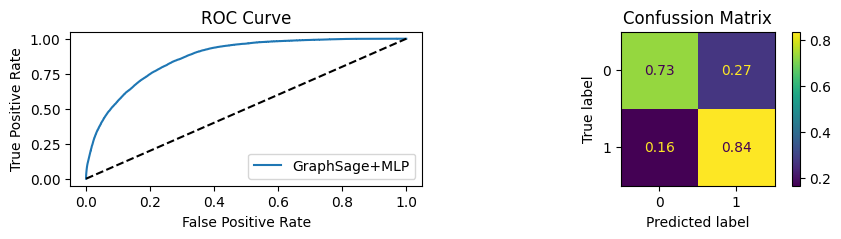

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 261: loss: 0.34254
Sensitivity (poss_acc):0.9362 Specificity (negative_acc):0.6633 accuracy:0.7998


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 262: loss: 0.33674
Sensitivity (poss_acc):0.8981 Specificity (negative_acc):0.7273 accuracy:0.8127


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 263: loss: 0.38279
Sensitivity (poss_acc):0.5439 Specificity (negative_acc):0.8548 accuracy:0.6994


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 264: loss: 0.48767
Sensitivity (poss_acc):0.8254 Specificity (negative_acc):0.7355 accuracy:0.7805


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 265: loss: 0.36447
Sensitivity (poss_acc):0.8628 Specificity (negative_acc):0.7420 accuracy:0.8024


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 266: loss: 0.34492
Sensitivity (poss_acc):0.9068 Specificity (negative_acc):0.7151 accuracy:0.8109


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 267: loss: 0.32435
Sensitivity (poss_acc):0.9105 Specificity (negative_acc):0.7026 accuracy:0.8065


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 268: loss: 0.32409
Sensitivity (poss_acc):0.9014 Specificity (negative_acc):0.7120 accuracy:0.8067


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 269: loss: 0.32108
Sensitivity (poss_acc):0.9313 Specificity (negative_acc):0.6747 accuracy:0.8030


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 270: loss: 0.3237
Sensitivity (poss_acc):0.9210 Specificity (negative_acc):0.7061 accuracy:0.8135


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 271: loss: 0.32685
Sensitivity (poss_acc):0.9401 Specificity (negative_acc):0.6747 accuracy:0.8074


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 272: loss: 0.32929
Sensitivity (poss_acc):0.9032 Specificity (negative_acc):0.7093 accuracy:0.8062


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 273: loss: 0.31754
Sensitivity (poss_acc):0.8953 Specificity (negative_acc):0.7217 accuracy:0.8085


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 274: loss: 0.31051
Sensitivity (poss_acc):0.9149 Specificity (negative_acc):0.7113 accuracy:0.8131


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 275: loss: 0.30441
Sensitivity (poss_acc):0.8978 Specificity (negative_acc):0.7097 accuracy:0.8038


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 276: loss: 0.31611
Sensitivity (poss_acc):0.9033 Specificity (negative_acc):0.7165 accuracy:0.8099


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 277: loss: 0.339
Sensitivity (poss_acc):0.9191 Specificity (negative_acc):0.6874 accuracy:0.8032


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 278: loss: 0.30854
Sensitivity (poss_acc):0.8892 Specificity (negative_acc):0.7273 accuracy:0.8083


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 279: loss: 0.30588
Sensitivity (poss_acc):0.9110 Specificity (negative_acc):0.7136 accuracy:0.8123


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 280: loss: 0.3044
Youdens  index: 0.8684 Sensitivity: 0.8255 Specificity: 0.7423


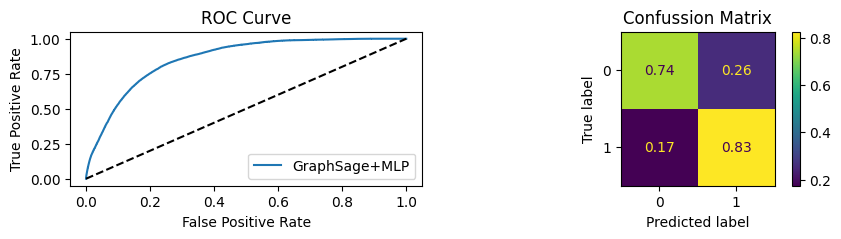

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 281: loss: 0.31266
Sensitivity (poss_acc):0.9100 Specificity (negative_acc):0.7139 accuracy:0.8119


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 282: loss: 0.34434
Sensitivity (poss_acc):0.9148 Specificity (negative_acc):0.6951 accuracy:0.8050


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 283: loss: 0.356
Sensitivity (poss_acc):0.9467 Specificity (negative_acc):0.6041 accuracy:0.7754


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 284: loss: 0.37104
Sensitivity (poss_acc):0.9132 Specificity (negative_acc):0.7085 accuracy:0.8109


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 285: loss: 0.41003
Sensitivity (poss_acc):0.9130 Specificity (negative_acc):0.6852 accuracy:0.7991


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 286: loss: 0.31963
Sensitivity (poss_acc):0.9146 Specificity (negative_acc):0.7064 accuracy:0.8105


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 287: loss: 0.29864
Sensitivity (poss_acc):0.9220 Specificity (negative_acc):0.6982 accuracy:0.8101


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 288: loss: 0.29035
Sensitivity (poss_acc):0.9211 Specificity (negative_acc):0.7120 accuracy:0.8166


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 289: loss: 0.28872
Sensitivity (poss_acc):0.9180 Specificity (negative_acc):0.7109 accuracy:0.8144


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 290: loss: 0.2885
Sensitivity (poss_acc):0.9079 Specificity (negative_acc):0.7042 accuracy:0.8061


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 291: loss: 0.28131
Sensitivity (poss_acc):0.9179 Specificity (negative_acc):0.7221 accuracy:0.8200
Replacing models: GraphSage_epoch_206.pt  link_predictor_epoch_206.pt
with: Best models at GraphSage_epoch_291.pt  link_predictor_epoch_291.pt
Saving Model in Path GraphSage_epoch_291.pt
Saving Model in Path link_predictor_epoch_291.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 292: loss: 0.28524
Sensitivity (poss_acc):0.9307 Specificity (negative_acc):0.6792 accuracy:0.8050


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 293: loss: 0.27918
Sensitivity (poss_acc):0.9019 Specificity (negative_acc):0.7214 accuracy:0.8116


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 294: loss: 0.28873
Sensitivity (poss_acc):0.9255 Specificity (negative_acc):0.6810 accuracy:0.8033


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 295: loss: 0.29937
Sensitivity (poss_acc):0.9420 Specificity (negative_acc):0.6690 accuracy:0.8055


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 296: loss: 0.31016
Sensitivity (poss_acc):0.9117 Specificity (negative_acc):0.6966 accuracy:0.8042


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 297: loss: 0.31863
Sensitivity (poss_acc):0.8969 Specificity (negative_acc):0.7367 accuracy:0.8168


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 298: loss: 0.30645
Sensitivity (poss_acc):0.9004 Specificity (negative_acc):0.7192 accuracy:0.8098


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 299: loss: 0.32054
Sensitivity (poss_acc):0.9291 Specificity (negative_acc):0.6969 accuracy:0.8130


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 300: loss: 0.32326
Youdens  index: 0.8774 Sensitivity: 0.8498 Specificity: 0.737


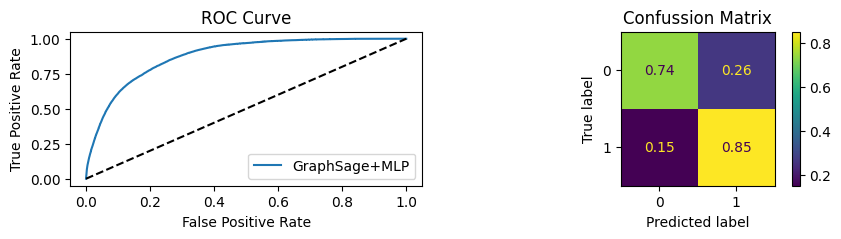

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 301: loss: 0.29137
Sensitivity (poss_acc):0.9161 Specificity (negative_acc):0.7305 accuracy:0.8233
Replacing models: GraphSage_epoch_291.pt  link_predictor_epoch_291.pt
with: Best models at GraphSage_epoch_301.pt  link_predictor_epoch_301.pt
Saving Model in Path GraphSage_epoch_301.pt
Saving Model in Path link_predictor_epoch_301.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 302: loss: 0.30295
Sensitivity (poss_acc):0.9140 Specificity (negative_acc):0.7151 accuracy:0.8146


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 303: loss: 0.29503
Sensitivity (poss_acc):0.9399 Specificity (negative_acc):0.7023 accuracy:0.8211


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 304: loss: 0.27937
Sensitivity (poss_acc):0.9195 Specificity (negative_acc):0.7122 accuracy:0.8159


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 305: loss: 0.29081
Sensitivity (poss_acc):0.9257 Specificity (negative_acc):0.6959 accuracy:0.8108


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 306: loss: 0.31621
Sensitivity (poss_acc):0.9212 Specificity (negative_acc):0.7136 accuracy:0.8174


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 307: loss: 0.27997
Sensitivity (poss_acc):0.9203 Specificity (negative_acc):0.7062 accuracy:0.8133


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 308: loss: 0.3185
Sensitivity (poss_acc):0.8559 Specificity (negative_acc):0.7480 accuracy:0.8020


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 309: loss: 0.3216
Sensitivity (poss_acc):0.9458 Specificity (negative_acc):0.6806 accuracy:0.8132


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 310: loss: 0.32574
Sensitivity (poss_acc):0.9323 Specificity (negative_acc):0.7062 accuracy:0.8193


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 311: loss: 0.2875
Sensitivity (poss_acc):0.9044 Specificity (negative_acc):0.7480 accuracy:0.8262
Replacing models: GraphSage_epoch_301.pt  link_predictor_epoch_301.pt
with: Best models at GraphSage_epoch_311.pt  link_predictor_epoch_311.pt
Saving Model in Path GraphSage_epoch_311.pt
Saving Model in Path link_predictor_epoch_311.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 312: loss: 0.26868
Sensitivity (poss_acc):0.9264 Specificity (negative_acc):0.7044 accuracy:0.8154


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 313: loss: 0.26539
Sensitivity (poss_acc):0.9263 Specificity (negative_acc):0.7039 accuracy:0.8151


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 314: loss: 0.27278
Sensitivity (poss_acc):0.9304 Specificity (negative_acc):0.7035 accuracy:0.8170


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 315: loss: 0.27866
Sensitivity (poss_acc):0.9092 Specificity (negative_acc):0.7336 accuracy:0.8214


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 316: loss: 0.27996
Sensitivity (poss_acc):0.9247 Specificity (negative_acc):0.7157 accuracy:0.8202


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 317: loss: 0.2774
Sensitivity (poss_acc):0.9422 Specificity (negative_acc):0.6833 accuracy:0.8127


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 318: loss: 0.29832
Sensitivity (poss_acc):0.9286 Specificity (negative_acc):0.6972 accuracy:0.8129


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 319: loss: 0.31629
Sensitivity (poss_acc):0.9385 Specificity (negative_acc):0.6817 accuracy:0.8101


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 320: loss: 0.29874
Youdens  index: 0.6011 Sensitivity: 0.8919 Specificity: 0.6917


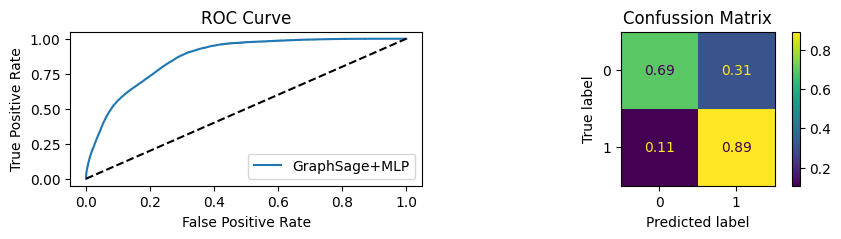

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 321: loss: 0.27478
Sensitivity (poss_acc):0.9296 Specificity (negative_acc):0.7037 accuracy:0.8166


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 322: loss: 0.26487
Sensitivity (poss_acc):0.9121 Specificity (negative_acc):0.7153 accuracy:0.8137


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 323: loss: 0.2636
Sensitivity (poss_acc):0.9221 Specificity (negative_acc):0.7217 accuracy:0.8219


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 324: loss: 0.26743
Sensitivity (poss_acc):0.9144 Specificity (negative_acc):0.7314 accuracy:0.8229


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 325: loss: 0.26381
Sensitivity (poss_acc):0.9418 Specificity (negative_acc):0.6830 accuracy:0.8124


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 326: loss: 0.26971
Sensitivity (poss_acc):0.9278 Specificity (negative_acc):0.7047 accuracy:0.8162


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 327: loss: 0.29703
Sensitivity (poss_acc):0.8546 Specificity (negative_acc):0.7918 accuracy:0.8232


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 328: loss: 0.31146
Sensitivity (poss_acc):0.8838 Specificity (negative_acc):0.7442 accuracy:0.8140


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 329: loss: 0.27847
Sensitivity (poss_acc):0.9403 Specificity (negative_acc):0.6829 accuracy:0.8116


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 330: loss: 0.26299
Sensitivity (poss_acc):0.9354 Specificity (negative_acc):0.7072 accuracy:0.8213


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 331: loss: 0.26303
Sensitivity (poss_acc):0.9154 Specificity (negative_acc):0.7331 accuracy:0.8243


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 332: loss: 0.25426
Sensitivity (poss_acc):0.9239 Specificity (negative_acc):0.7059 accuracy:0.8149


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 333: loss: 0.25015
Sensitivity (poss_acc):0.9082 Specificity (negative_acc):0.7338 accuracy:0.8210


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 334: loss: 0.26118
Sensitivity (poss_acc):0.9227 Specificity (negative_acc):0.7164 accuracy:0.8196


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 335: loss: 0.25302
Sensitivity (poss_acc):0.9286 Specificity (negative_acc):0.7148 accuracy:0.8217


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 336: loss: 0.25933
Sensitivity (poss_acc):0.9413 Specificity (negative_acc):0.6888 accuracy:0.8150


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 337: loss: 0.28035
Sensitivity (poss_acc):0.9063 Specificity (negative_acc):0.7286 accuracy:0.8174


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 338: loss: 0.25494
Sensitivity (poss_acc):0.9229 Specificity (negative_acc):0.7104 accuracy:0.8167


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 339: loss: 0.24699
Sensitivity (poss_acc):0.9201 Specificity (negative_acc):0.7101 accuracy:0.8151


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 340: loss: 0.24394
Youdens  index: 0.8950 Sensitivity: 0.8676 Specificity: 0.7121


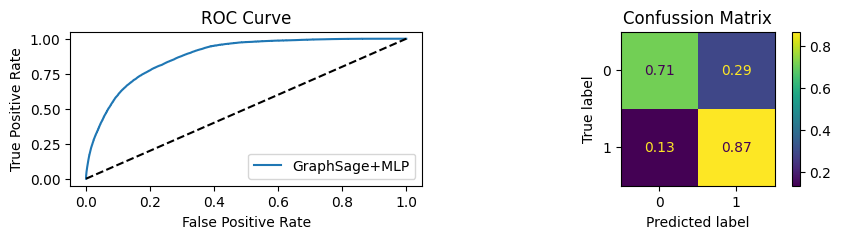

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 341: loss: 0.24413
Sensitivity (poss_acc):0.8992 Specificity (negative_acc):0.7515 accuracy:0.8254


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 342: loss: 0.24053
Sensitivity (poss_acc):0.9398 Specificity (negative_acc):0.6915 accuracy:0.8157


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 343: loss: 0.29209
Sensitivity (poss_acc):0.9573 Specificity (negative_acc):0.6284 accuracy:0.7929


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 344: loss: 0.48287
Sensitivity (poss_acc):0.8723 Specificity (negative_acc):0.7623 accuracy:0.8173


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 345: loss: 0.35241
Sensitivity (poss_acc):0.9142 Specificity (negative_acc):0.7485 accuracy:0.8313
Replacing models: GraphSage_epoch_311.pt  link_predictor_epoch_311.pt
with: Best models at GraphSage_epoch_345.pt  link_predictor_epoch_345.pt
Saving Model in Path GraphSage_epoch_345.pt
Saving Model in Path link_predictor_epoch_345.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 346: loss: 0.27701
Sensitivity (poss_acc):0.9462 Specificity (negative_acc):0.6819 accuracy:0.8140


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 347: loss: 0.25205
Sensitivity (poss_acc):0.9063 Specificity (negative_acc):0.7409 accuracy:0.8236


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 348: loss: 0.24887
Sensitivity (poss_acc):0.9463 Specificity (negative_acc):0.6827 accuracy:0.8145


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 349: loss: 0.24235
Sensitivity (poss_acc):0.9327 Specificity (negative_acc):0.7253 accuracy:0.8290


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 350: loss: 0.24123
Sensitivity (poss_acc):0.9439 Specificity (negative_acc):0.6913 accuracy:0.8176


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 351: loss: 0.24302
Sensitivity (poss_acc):0.9240 Specificity (negative_acc):0.6951 accuracy:0.8095


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 352: loss: 0.24553
Sensitivity (poss_acc):0.9193 Specificity (negative_acc):0.7285 accuracy:0.8239


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 353: loss: 0.23427
Sensitivity (poss_acc):0.9197 Specificity (negative_acc):0.7387 accuracy:0.8292


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 354: loss: 0.2294
Sensitivity (poss_acc):0.9341 Specificity (negative_acc):0.6866 accuracy:0.8104


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 355: loss: 0.23221
Sensitivity (poss_acc):0.9356 Specificity (negative_acc):0.7092 accuracy:0.8224


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 356: loss: 0.22796
Sensitivity (poss_acc):0.9188 Specificity (negative_acc):0.7202 accuracy:0.8195


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 357: loss: 0.23815
Sensitivity (poss_acc):0.9420 Specificity (negative_acc):0.6986 accuracy:0.8203


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 358: loss: 0.24684
Sensitivity (poss_acc):0.9355 Specificity (negative_acc):0.6995 accuracy:0.8175


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 359: loss: 0.25699
Sensitivity (poss_acc):0.9266 Specificity (negative_acc):0.7014 accuracy:0.8140


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 360: loss: 0.26083
Youdens  index: 0.9143 Sensitivity: 0.8573 Specificity: 0.7576


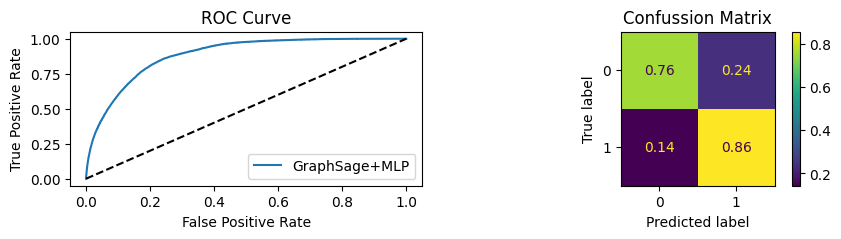

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 361: loss: 0.25936
Sensitivity (poss_acc):0.9076 Specificity (negative_acc):0.7554 accuracy:0.8315
Replacing models: GraphSage_epoch_345.pt  link_predictor_epoch_345.pt
with: Best models at GraphSage_epoch_361.pt  link_predictor_epoch_361.pt
Saving Model in Path GraphSage_epoch_361.pt
Saving Model in Path link_predictor_epoch_361.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 362: loss: 0.24979
Sensitivity (poss_acc):0.9259 Specificity (negative_acc):0.7303 accuracy:0.8281


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 363: loss: 0.23555
Sensitivity (poss_acc):0.9424 Specificity (negative_acc):0.6934 accuracy:0.8179


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 364: loss: 0.24072
Sensitivity (poss_acc):0.9233 Specificity (negative_acc):0.7338 accuracy:0.8285


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 365: loss: 0.24204
Sensitivity (poss_acc):0.9306 Specificity (negative_acc):0.7124 accuracy:0.8215


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 366: loss: 0.23186
Sensitivity (poss_acc):0.9369 Specificity (negative_acc):0.6904 accuracy:0.8136


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 367: loss: 0.22834
Sensitivity (poss_acc):0.9331 Specificity (negative_acc):0.6955 accuracy:0.8143


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 368: loss: 0.22755
Sensitivity (poss_acc):0.9359 Specificity (negative_acc):0.6992 accuracy:0.8175


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 369: loss: 0.22694
Sensitivity (poss_acc):0.9377 Specificity (negative_acc):0.6754 accuracy:0.8066


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 370: loss: 0.26628
Sensitivity (poss_acc):0.9138 Specificity (negative_acc):0.7267 accuracy:0.8202


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 371: loss: 0.23757
Sensitivity (poss_acc):0.9161 Specificity (negative_acc):0.7257 accuracy:0.8209


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 372: loss: 0.23516
Sensitivity (poss_acc):0.9381 Specificity (negative_acc):0.7021 accuracy:0.8201


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 373: loss: 0.23502
Sensitivity (poss_acc):0.9255 Specificity (negative_acc):0.7370 accuracy:0.8312


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 374: loss: 0.23408
Sensitivity (poss_acc):0.9201 Specificity (negative_acc):0.7220 accuracy:0.8210


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 375: loss: 0.24173
Sensitivity (poss_acc):0.9111 Specificity (negative_acc):0.7324 accuracy:0.8218


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 376: loss: 0.24685
Sensitivity (poss_acc):0.9111 Specificity (negative_acc):0.7398 accuracy:0.8254


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 377: loss: 0.24181
Sensitivity (poss_acc):0.9347 Specificity (negative_acc):0.7024 accuracy:0.8186


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 378: loss: 0.25231
Sensitivity (poss_acc):0.9276 Specificity (negative_acc):0.6988 accuracy:0.8132


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 379: loss: 0.24032
Sensitivity (poss_acc):0.9296 Specificity (negative_acc):0.6854 accuracy:0.8075


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 380: loss: 0.2515
Youdens  index: 0.9390 Sensitivity: 0.8487 Specificity: 0.7432


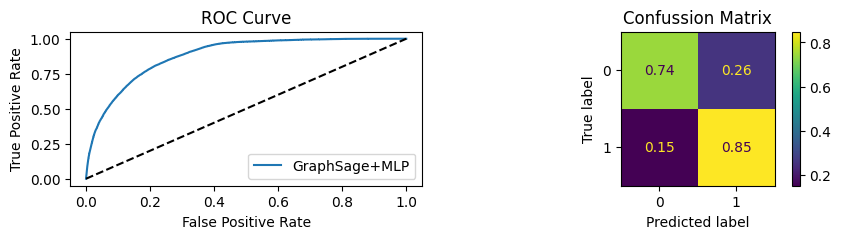

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 381: loss: 0.27215
Sensitivity (poss_acc):0.9264 Specificity (negative_acc):0.7043 accuracy:0.8154


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 382: loss: 0.27327
Sensitivity (poss_acc):0.8217 Specificity (negative_acc):0.8156 accuracy:0.8186


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 383: loss: 0.24583
Sensitivity (poss_acc):0.9425 Specificity (negative_acc):0.6963 accuracy:0.8194


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 384: loss: 0.22456
Sensitivity (poss_acc):0.9361 Specificity (negative_acc):0.7006 accuracy:0.8183


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 385: loss: 0.22032
Sensitivity (poss_acc):0.9157 Specificity (negative_acc):0.7279 accuracy:0.8218


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 386: loss: 0.2244
Sensitivity (poss_acc):0.9160 Specificity (negative_acc):0.7137 accuracy:0.8148


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 387: loss: 0.21072
Sensitivity (poss_acc):0.9096 Specificity (negative_acc):0.7449 accuracy:0.8273


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 388: loss: 0.2204
Sensitivity (poss_acc):0.9345 Specificity (negative_acc):0.7072 accuracy:0.8208


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 389: loss: 0.21742
Sensitivity (poss_acc):0.9376 Specificity (negative_acc):0.7054 accuracy:0.8215


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 390: loss: 0.2208
Sensitivity (poss_acc):0.9231 Specificity (negative_acc):0.7287 accuracy:0.8259


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 391: loss: 0.21633
Sensitivity (poss_acc):0.9181 Specificity (negative_acc):0.7176 accuracy:0.8179


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 392: loss: 0.2131
Sensitivity (poss_acc):0.9095 Specificity (negative_acc):0.7374 accuracy:0.8234


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 393: loss: 0.20912
Sensitivity (poss_acc):0.9370 Specificity (negative_acc):0.7129 accuracy:0.8249


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 394: loss: 0.20719
Sensitivity (poss_acc):0.9170 Specificity (negative_acc):0.7373 accuracy:0.8271


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 395: loss: 0.22036
Sensitivity (poss_acc):0.9067 Specificity (negative_acc):0.7465 accuracy:0.8266


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 396: loss: 0.24959
Sensitivity (poss_acc):0.9254 Specificity (negative_acc):0.7150 accuracy:0.8202


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 397: loss: 0.23008
Sensitivity (poss_acc):0.9188 Specificity (negative_acc):0.7329 accuracy:0.8259


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 398: loss: 0.21689
Sensitivity (poss_acc):0.9142 Specificity (negative_acc):0.7152 accuracy:0.8147


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 399: loss: 0.22647
Sensitivity (poss_acc):0.9370 Specificity (negative_acc):0.7086 accuracy:0.8228


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 400: loss: 0.22033
Youdens  index: 0.8356 Sensitivity: 0.8722 Specificity: 0.738


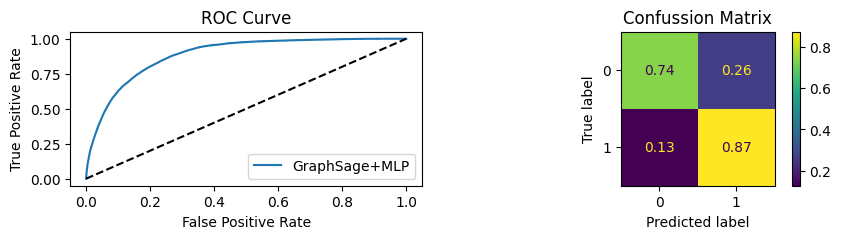

Replacing models: GraphSage_epoch_361.pt  link_predictor_epoch_361.pt
with: Best models at GraphSage_epoch_400.pt  link_predictor_epoch_400.pt
Saving Model in Path GraphSage_epoch_400.pt
Saving Model in Path link_predictor_epoch_400.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 401: loss: 0.22417
Sensitivity (poss_acc):0.9385 Specificity (negative_acc):0.6754 accuracy:0.8070


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 402: loss: 0.22036
Sensitivity (poss_acc):0.9273 Specificity (negative_acc):0.7116 accuracy:0.8195


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 403: loss: 0.22335
Sensitivity (poss_acc):0.9309 Specificity (negative_acc):0.7180 accuracy:0.8244


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 404: loss: 0.21484
Sensitivity (poss_acc):0.8955 Specificity (negative_acc):0.7831 accuracy:0.8393
Replacing models: GraphSage_epoch_400.pt  link_predictor_epoch_400.pt
with: Best models at GraphSage_epoch_404.pt  link_predictor_epoch_404.pt
Saving Model in Path GraphSage_epoch_404.pt
Saving Model in Path link_predictor_epoch_404.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 405: loss: 0.22207
Sensitivity (poss_acc):0.9363 Specificity (negative_acc):0.6996 accuracy:0.8179


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 406: loss: 0.24823
Sensitivity (poss_acc):0.9283 Specificity (negative_acc):0.7215 accuracy:0.8249


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 407: loss: 0.22388
Sensitivity (poss_acc):0.9247 Specificity (negative_acc):0.7464 accuracy:0.8355


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 408: loss: 0.21491
Sensitivity (poss_acc):0.9214 Specificity (negative_acc):0.7454 accuracy:0.8334


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 409: loss: 0.20652
Sensitivity (poss_acc):0.9119 Specificity (negative_acc):0.7507 accuracy:0.8313


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 410: loss: 0.20941
Sensitivity (poss_acc):0.8952 Specificity (negative_acc):0.7374 accuracy:0.8163


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 411: loss: 0.22706
Sensitivity (poss_acc):0.9301 Specificity (negative_acc):0.7208 accuracy:0.8255


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 412: loss: 0.21377
Sensitivity (poss_acc):0.9152 Specificity (negative_acc):0.7346 accuracy:0.8249


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 413: loss: 0.23774
Sensitivity (poss_acc):0.8829 Specificity (negative_acc):0.7607 accuracy:0.8218


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 414: loss: 0.21501
Sensitivity (poss_acc):0.9251 Specificity (negative_acc):0.7199 accuracy:0.8225


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 415: loss: 0.21192
Sensitivity (poss_acc):0.9258 Specificity (negative_acc):0.7120 accuracy:0.8189


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 416: loss: 0.2122
Sensitivity (poss_acc):0.9350 Specificity (negative_acc):0.7126 accuracy:0.8238


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 417: loss: 0.20387
Sensitivity (poss_acc):0.9221 Specificity (negative_acc):0.7249 accuracy:0.8235


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 418: loss: 0.19571
Sensitivity (poss_acc):0.9287 Specificity (negative_acc):0.7219 accuracy:0.8253


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 419: loss: 0.19462
Sensitivity (poss_acc):0.9441 Specificity (negative_acc):0.6975 accuracy:0.8208


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 420: loss: 0.1974
Youdens  index: 0.9035 Sensitivity: 0.8457 Specificity: 0.7657


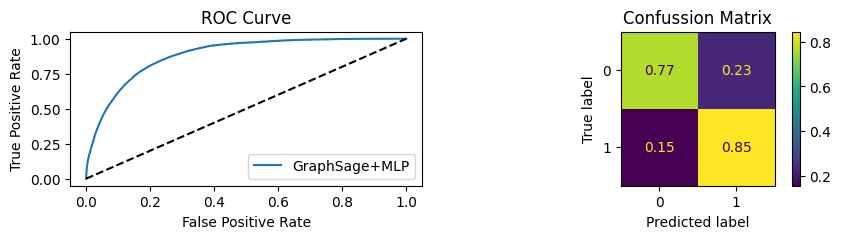

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 421: loss: 0.24172
Sensitivity (poss_acc):0.9244 Specificity (negative_acc):0.7144 accuracy:0.8194


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 422: loss: 0.20444
Sensitivity (poss_acc):0.9205 Specificity (negative_acc):0.7327 accuracy:0.8266


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 423: loss: 0.20627
Sensitivity (poss_acc):0.9069 Specificity (negative_acc):0.7523 accuracy:0.8296


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 424: loss: 0.21716
Sensitivity (poss_acc):0.9253 Specificity (negative_acc):0.7196 accuracy:0.8224


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 425: loss: 0.28508
Sensitivity (poss_acc):0.8785 Specificity (negative_acc):0.7684 accuracy:0.8234


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 426: loss: 0.39432
Sensitivity (poss_acc):0.9058 Specificity (negative_acc):0.7272 accuracy:0.8165


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 427: loss: 0.29863
Sensitivity (poss_acc):0.9264 Specificity (negative_acc):0.7209 accuracy:0.8237


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 428: loss: 0.23338
Sensitivity (poss_acc):0.9358 Specificity (negative_acc):0.6780 accuracy:0.8069


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 429: loss: 0.21444
Sensitivity (poss_acc):0.9156 Specificity (negative_acc):0.7380 accuracy:0.8268


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 430: loss: 0.19334
Sensitivity (poss_acc):0.9283 Specificity (negative_acc):0.7225 accuracy:0.8254


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 431: loss: 0.19064
Sensitivity (poss_acc):0.9279 Specificity (negative_acc):0.7242 accuracy:0.8261


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 432: loss: 0.19181
Sensitivity (poss_acc):0.9396 Specificity (negative_acc):0.7197 accuracy:0.8297


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 433: loss: 0.18775
Sensitivity (poss_acc):0.9438 Specificity (negative_acc):0.6887 accuracy:0.8163


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 434: loss: 0.18864
Sensitivity (poss_acc):0.9294 Specificity (negative_acc):0.7217 accuracy:0.8256


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 435: loss: 0.19959
Sensitivity (poss_acc):0.9110 Specificity (negative_acc):0.7340 accuracy:0.8225


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 436: loss: 0.20152
Sensitivity (poss_acc):0.9224 Specificity (negative_acc):0.7323 accuracy:0.8274


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 437: loss: 0.19882
Sensitivity (poss_acc):0.9302 Specificity (negative_acc):0.7252 accuracy:0.8277


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 438: loss: 0.20474
Sensitivity (poss_acc):0.9112 Specificity (negative_acc):0.7511 accuracy:0.8312


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 439: loss: 0.19753
Sensitivity (poss_acc):0.9229 Specificity (negative_acc):0.7317 accuracy:0.8273


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 440: loss: 0.18248
Youdens  index: 0.9178 Sensitivity: 0.8538 Specificity: 0.749


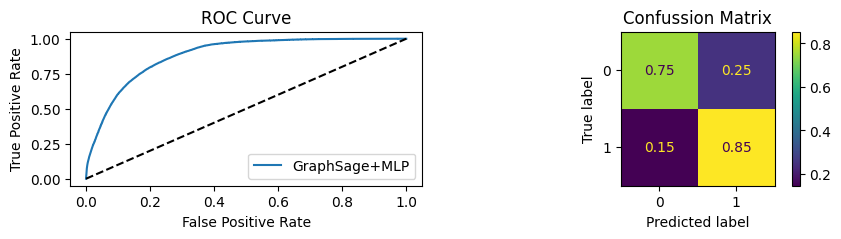

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 441: loss: 0.18211
Sensitivity (poss_acc):0.9333 Specificity (negative_acc):0.7213 accuracy:0.8273


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 442: loss: 0.17687
Sensitivity (poss_acc):0.9340 Specificity (negative_acc):0.7109 accuracy:0.8225


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 443: loss: 0.17796
Sensitivity (poss_acc):0.9253 Specificity (negative_acc):0.7260 accuracy:0.8256


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 444: loss: 0.19276
Sensitivity (poss_acc):0.9328 Specificity (negative_acc):0.7184 accuracy:0.8256


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 445: loss: 0.20067
Sensitivity (poss_acc):0.9249 Specificity (negative_acc):0.7290 accuracy:0.8269


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 446: loss: 0.20874
Sensitivity (poss_acc):0.9373 Specificity (negative_acc):0.6993 accuracy:0.8183


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 447: loss: 0.1938
Sensitivity (poss_acc):0.9313 Specificity (negative_acc):0.7128 accuracy:0.8221


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 448: loss: 0.18856
Sensitivity (poss_acc):0.9137 Specificity (negative_acc):0.7146 accuracy:0.8142


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 449: loss: 0.22809
Sensitivity (poss_acc):0.9370 Specificity (negative_acc):0.6977 accuracy:0.8173


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 450: loss: 0.19334
Sensitivity (poss_acc):0.9231 Specificity (negative_acc):0.7362 accuracy:0.8297


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 451: loss: 0.19978
Sensitivity (poss_acc):0.9325 Specificity (negative_acc):0.7207 accuracy:0.8266


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 452: loss: 0.20199
Sensitivity (poss_acc):0.9299 Specificity (negative_acc):0.7205 accuracy:0.8252


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 453: loss: 0.1864
Sensitivity (poss_acc):0.9242 Specificity (negative_acc):0.7348 accuracy:0.8295


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 454: loss: 0.19218
Sensitivity (poss_acc):0.9217 Specificity (negative_acc):0.7288 accuracy:0.8253


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 455: loss: 0.18319
Sensitivity (poss_acc):0.9125 Specificity (negative_acc):0.7487 accuracy:0.8306


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 456: loss: 0.19585
Sensitivity (poss_acc):0.9286 Specificity (negative_acc):0.7104 accuracy:0.8195


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 457: loss: 0.18792
Sensitivity (poss_acc):0.9224 Specificity (negative_acc):0.7201 accuracy:0.8213


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 458: loss: 0.18575
Sensitivity (poss_acc):0.9269 Specificity (negative_acc):0.7318 accuracy:0.8293


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 459: loss: 0.17877
Sensitivity (poss_acc):0.9342 Specificity (negative_acc):0.7272 accuracy:0.8307


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 460: loss: 0.19606
Youdens  index: 0.7920 Sensitivity: 0.8774 Specificity: 0.7214


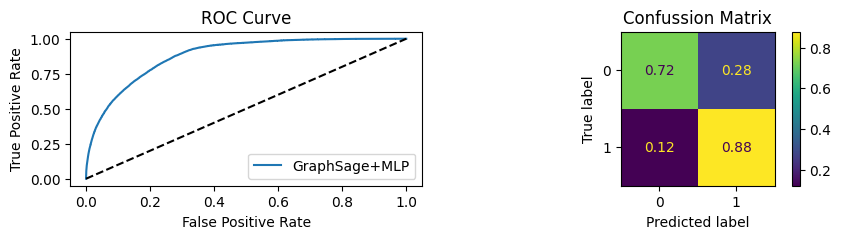

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 461: loss: 0.23033
Sensitivity (poss_acc):0.9176 Specificity (negative_acc):0.7411 accuracy:0.8293


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 462: loss: 0.25767
Sensitivity (poss_acc):0.8857 Specificity (negative_acc):0.7621 accuracy:0.8239


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 463: loss: 0.2143
Sensitivity (poss_acc):0.9285 Specificity (negative_acc):0.7370 accuracy:0.8328


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 464: loss: 0.23429
Sensitivity (poss_acc):0.9166 Specificity (negative_acc):0.7064 accuracy:0.8115


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 465: loss: 0.21986
Sensitivity (poss_acc):0.9254 Specificity (negative_acc):0.7141 accuracy:0.8197


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 466: loss: 0.19238
Sensitivity (poss_acc):0.9403 Specificity (negative_acc):0.7151 accuracy:0.8277


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 467: loss: 0.17515
Sensitivity (poss_acc):0.9365 Specificity (negative_acc):0.7148 accuracy:0.8257


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 468: loss: 0.17223
Sensitivity (poss_acc):0.9265 Specificity (negative_acc):0.7199 accuracy:0.8232


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 469: loss: 0.16581
Sensitivity (poss_acc):0.9277 Specificity (negative_acc):0.7230 accuracy:0.8254


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 470: loss: 0.16664
Sensitivity (poss_acc):0.9215 Specificity (negative_acc):0.7201 accuracy:0.8208


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 471: loss: 0.16958
Sensitivity (poss_acc):0.9336 Specificity (negative_acc):0.7371 accuracy:0.8354


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 472: loss: 0.17501
Sensitivity (poss_acc):0.9039 Specificity (negative_acc):0.7741 accuracy:0.8390


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 473: loss: 0.17548
Sensitivity (poss_acc):0.9379 Specificity (negative_acc):0.7026 accuracy:0.8203


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 474: loss: 0.17472
Sensitivity (poss_acc):0.9275 Specificity (negative_acc):0.7344 accuracy:0.8310


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 475: loss: 0.17299
Sensitivity (poss_acc):0.9281 Specificity (negative_acc):0.7269 accuracy:0.8275


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 476: loss: 0.17259
Sensitivity (poss_acc):0.9233 Specificity (negative_acc):0.7368 accuracy:0.8300


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 477: loss: 0.19387
Sensitivity (poss_acc):0.9349 Specificity (negative_acc):0.7090 accuracy:0.8219


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 478: loss: 0.23573
Sensitivity (poss_acc):0.9442 Specificity (negative_acc):0.6996 accuracy:0.8219


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 479: loss: 0.20471
Sensitivity (poss_acc):0.9392 Specificity (negative_acc):0.7077 accuracy:0.8235


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 480: loss: 0.18789
Youdens  index: 0.9204 Sensitivity: 0.8476 Specificity: 0.7796


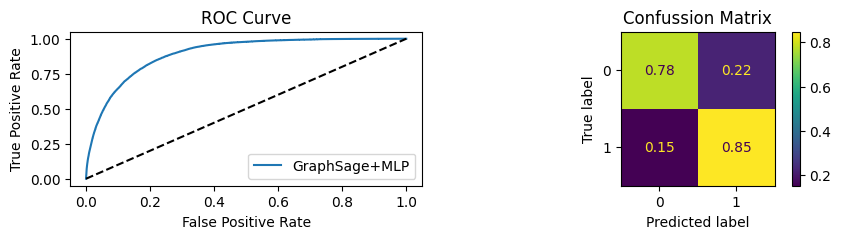

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 481: loss: 0.174
Sensitivity (poss_acc):0.9332 Specificity (negative_acc):0.7282 accuracy:0.8307


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 482: loss: 0.17244
Sensitivity (poss_acc):0.9079 Specificity (negative_acc):0.7520 accuracy:0.8299


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 483: loss: 0.17065
Sensitivity (poss_acc):0.9281 Specificity (negative_acc):0.7082 accuracy:0.8181


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 484: loss: 0.17275
Sensitivity (poss_acc):0.9237 Specificity (negative_acc):0.7147 accuracy:0.8192


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 485: loss: 0.1662
Sensitivity (poss_acc):0.9365 Specificity (negative_acc):0.7102 accuracy:0.8233


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 486: loss: 0.17545
Sensitivity (poss_acc):0.9126 Specificity (negative_acc):0.7429 accuracy:0.8277


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 487: loss: 0.16983
Sensitivity (poss_acc):0.9176 Specificity (negative_acc):0.7375 accuracy:0.8275


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 488: loss: 0.16665
Sensitivity (poss_acc):0.9228 Specificity (negative_acc):0.7365 accuracy:0.8297


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 489: loss: 0.18032
Sensitivity (poss_acc):0.9280 Specificity (negative_acc):0.7288 accuracy:0.8284


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 490: loss: 0.20371
Sensitivity (poss_acc):0.9155 Specificity (negative_acc):0.7284 accuracy:0.8220


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 491: loss: 0.20601
Sensitivity (poss_acc):0.9107 Specificity (negative_acc):0.7437 accuracy:0.8272


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 492: loss: 0.21267
Sensitivity (poss_acc):0.9346 Specificity (negative_acc):0.7217 accuracy:0.8282


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 493: loss: 0.19111
Sensitivity (poss_acc):0.9382 Specificity (negative_acc):0.7030 accuracy:0.8206


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 494: loss: 0.1703
Sensitivity (poss_acc):0.9303 Specificity (negative_acc):0.7277 accuracy:0.8290


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 495: loss: 0.16025
Sensitivity (poss_acc):0.9240 Specificity (negative_acc):0.7226 accuracy:0.8233


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 496: loss: 0.18236
Sensitivity (poss_acc):0.9057 Specificity (negative_acc):0.7365 accuracy:0.8211


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 497: loss: 0.18573
Sensitivity (poss_acc):0.9415 Specificity (negative_acc):0.7061 accuracy:0.8238


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 498: loss: 0.17085
Sensitivity (poss_acc):0.9250 Specificity (negative_acc):0.7054 accuracy:0.8152


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 499: loss: 0.17554
Sensitivity (poss_acc):0.9321 Specificity (negative_acc):0.7151 accuracy:0.8236
Loading best models:  GraphSage_epoch_404.pt  link_predictor_epoch_404.pt


In [190]:
train_loss                      = []
train_accuracy                  = []
show_metrics_every              = 20
best_accuracy                   = 0 
best_graphsage_model_path       = ""
best_link_predictor_model_path  = ""

for epoch in range(1,epochs):
    torch.cuda.empty_cache()
    gc.collect()
    
    ### TRAIN ####
    loss = train(model, link_predictor,train_loader, optimizer,device) # Get Loss
    train_loss.append(loss)
    print(f"Epoch {epoch}: loss: {round(loss, 5)}")
    
    ### EVALUATE ###
    if (epoch % 20 == 0) or (epoch ==1):
        accuracy = evaluate(model, link_predictor ,test_loader,device=device,best_accuracy=best_accuracy,show_extra_metrics=True)
        
    else:
        accuracy = evaluate(model, link_predictor ,test_loader,device=device,best_accuracy=best_accuracy)
    
    train_accuracy.append(accuracy)
    ### SAVE ###
    if best_accuracy < accuracy:
        if os.path.exists(best_graphsage_model_path):
            
            os.remove(best_graphsage_model_path)
            
        if os.path.exists(best_link_predictor_model_path):
            os.remove(best_link_predictor_model_path)
        print(f"Replacing models: {best_graphsage_model_path }  {best_link_predictor_model_path}")
            
        best_accuracy  = accuracy
        best_graphsage_model_path      = f"GraphSage_epoch_{epoch}.pt"
        best_link_predictor_model_path =  f"link_predictor_epoch_{epoch}.pt"
        print(f"with: Best models at {best_graphsage_model_path }  {best_link_predictor_model_path}")
        save_torch_model(model,         epoch=epoch,PATH=best_graphsage_model_path ,     optimizer=optimizer)
        save_torch_model(link_predictor,epoch=epoch,PATH=best_link_predictor_model_path, optimizer=optimizer)

        
#### Load Best Models ####

print(f"Loading best models:  {best_graphsage_model_path }  {best_link_predictor_model_path}")
checkpoint = torch.load(best_graphsage_model_path)
model.load_state_dict(checkpoint['model_state_dict'])

checkpoint = torch.load(best_link_predictor_model_path)
link_predictor.load_state_dict(checkpoint['model_state_dict'])

del checkpoint

In [18]:
torch.cuda.empty_cache()

Once the training is complete, we can load our best model and use it to see the AUC/ROC and Confussion matrix plot. Also, we can use it with validation data (comming!) to see how well this is performing.

In [19]:
model = GNNStack(input_dim, hidden_dim, hidden_dim, dropout,num_layers, emb=True).to(device)

best_graphsage_model_path      = f"GraphSage_epoch_{404}.pt"
best_link_predictor_model_path =  f"link_predictor_epoch_{404}.pt"

print(f"Loading best models:  {best_graphsage_model_path }  {best_link_predictor_model_path}")
checkpoint = torch.load(best_graphsage_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

checkpoint = torch.load(best_link_predictor_model_path)
link_predictor.load_state_dict(checkpoint['model_state_dict'])

del checkpoint

Loading best models:  GraphSage_epoch_404.pt  link_predictor_epoch_404.pt


Run this part, to see the loss and accuracy acroos the epochs:

In [ ]:
fig, ax = plt.subplots(1, 2,figsize=(10,4))

ax[0].set_title("Train Loss")
ax[0].plot(train_loss)
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epochs")

ax[1].set_title("Accuracy")
ax[1].plot(train_accuracy)
ax[1].set_ylabel("accuracy")
ax[1].set_xlabel("Epochs")
fig.tight_layout()
plt.show()

## Evaluate Diferent PPI Percentages

Is important to see how the model behaves with different percentages of protein-protein interactions:

Evaluating Model with 1.0% of PPI's
 371 Positive Protein Interactions were used to Embed a graph with 37140 ppi's
 149 Positive Protein Interactions were used to Embed a graph with 14908 ppi's
 284 Positive Protein Interactions were used to Embed a graph with 28466 ppi's
 150 Positive Protein Interactions were used to Embed a graph with 15022 ppi's
 172 Positive Protein Interactions were used to Embed a graph with 17228 ppi's
 261 Positive Protein Interactions were used to Embed a graph with 26124 ppi's
 52 Positive Protein Interactions were used to Embed a graph with 5284 ppi's
 63 Positive Protein Interactions were used to Embed a graph with 6366 ppi's
 148 Positive Protein Interactions were used to Embed a graph with 14870 ppi's
 79 Positive Protein Interactions were used to Embed a graph with 7918 ppi's
Youdens  index: 0.7248 Sensitivity: 0.035 Specificity: 0.9659


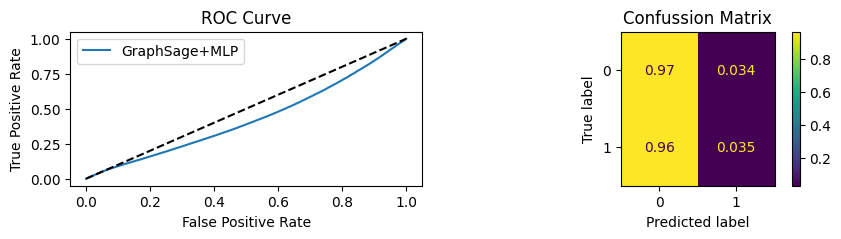


Evaluating Model with 10.0% of PPI's
 3714 Positive Protein Interactions were used to Embed a graph with 37140 ppi's
 1490 Positive Protein Interactions were used to Embed a graph with 14908 ppi's
 2846 Positive Protein Interactions were used to Embed a graph with 28466 ppi's
 1502 Positive Protein Interactions were used to Embed a graph with 15022 ppi's
 1722 Positive Protein Interactions were used to Embed a graph with 17228 ppi's
 2612 Positive Protein Interactions were used to Embed a graph with 26124 ppi's
 528 Positive Protein Interactions were used to Embed a graph with 5284 ppi's
 636 Positive Protein Interactions were used to Embed a graph with 6366 ppi's
 1487 Positive Protein Interactions were used to Embed a graph with 14870 ppi's
 791 Positive Protein Interactions were used to Embed a graph with 7918 ppi's
Youdens  index: 0.0496 Sensitivity: 0.6652 Specificity: 0.5561


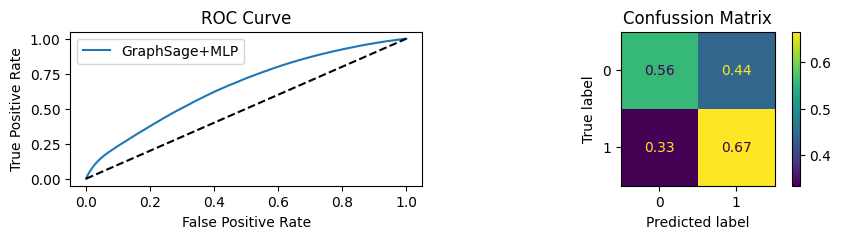


Evaluating Model with 20.0% of PPI's
 7428 Positive Protein Interactions were used to Embed a graph with 37140 ppi's
 2981 Positive Protein Interactions were used to Embed a graph with 14908 ppi's
 5693 Positive Protein Interactions were used to Embed a graph with 28466 ppi's
 3004 Positive Protein Interactions were used to Embed a graph with 15022 ppi's
 3445 Positive Protein Interactions were used to Embed a graph with 17228 ppi's
 5224 Positive Protein Interactions were used to Embed a graph with 26124 ppi's
 1056 Positive Protein Interactions were used to Embed a graph with 5284 ppi's
 1273 Positive Protein Interactions were used to Embed a graph with 6366 ppi's
 2974 Positive Protein Interactions were used to Embed a graph with 14870 ppi's
 1583 Positive Protein Interactions were used to Embed a graph with 7918 ppi's
Youdens  index: 0.1124 Sensitivity: 0.7235 Specificity: 0.6677


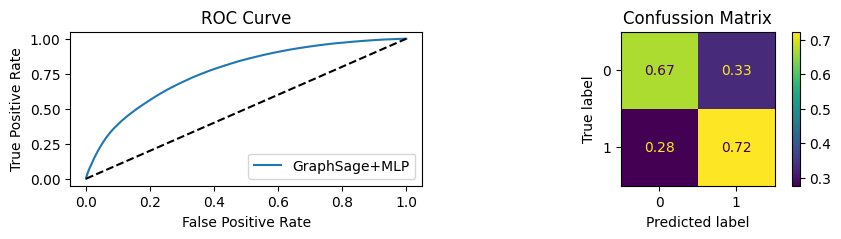


Evaluating Model with 30.0% of PPI's
 11142 Positive Protein Interactions were used to Embed a graph with 37140 ppi's
 4472 Positive Protein Interactions were used to Embed a graph with 14908 ppi's
 8539 Positive Protein Interactions were used to Embed a graph with 28466 ppi's
 4506 Positive Protein Interactions were used to Embed a graph with 15022 ppi's
 5168 Positive Protein Interactions were used to Embed a graph with 17228 ppi's
 7837 Positive Protein Interactions were used to Embed a graph with 26124 ppi's
 1585 Positive Protein Interactions were used to Embed a graph with 5284 ppi's
 1909 Positive Protein Interactions were used to Embed a graph with 6366 ppi's
 4461 Positive Protein Interactions were used to Embed a graph with 14870 ppi's
 2375 Positive Protein Interactions were used to Embed a graph with 7918 ppi's
Youdens  index: 0.1843 Sensitivity: 0.7657 Specificity: 0.7335


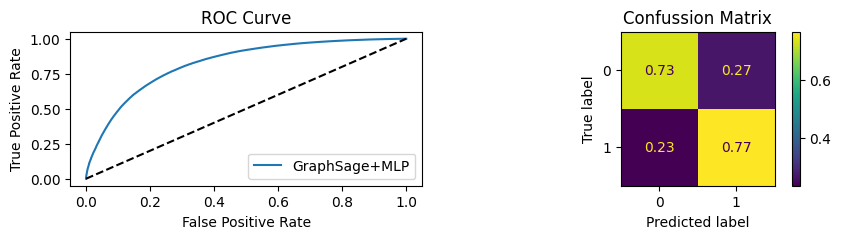


Evaluating Model with 40.0% of PPI's
 14856 Positive Protein Interactions were used to Embed a graph with 37140 ppi's
 5963 Positive Protein Interactions were used to Embed a graph with 14908 ppi's
 11386 Positive Protein Interactions were used to Embed a graph with 28466 ppi's
 6008 Positive Protein Interactions were used to Embed a graph with 15022 ppi's
 6891 Positive Protein Interactions were used to Embed a graph with 17228 ppi's
 10449 Positive Protein Interactions were used to Embed a graph with 26124 ppi's
 2113 Positive Protein Interactions were used to Embed a graph with 5284 ppi's
 2546 Positive Protein Interactions were used to Embed a graph with 6366 ppi's
 5948 Positive Protein Interactions were used to Embed a graph with 14870 ppi's
 3167 Positive Protein Interactions were used to Embed a graph with 7918 ppi's
Youdens  index: 0.2490 Sensitivity: 0.7996 Specificity: 0.7621


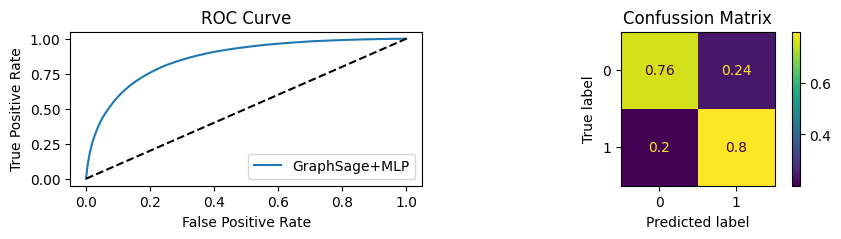


Evaluating Model with 50.0% of PPI's
 18570 Positive Protein Interactions were used to Embed a graph with 37140 ppi's
 7454 Positive Protein Interactions were used to Embed a graph with 14908 ppi's
 14233 Positive Protein Interactions were used to Embed a graph with 28466 ppi's
 7511 Positive Protein Interactions were used to Embed a graph with 15022 ppi's
 8614 Positive Protein Interactions were used to Embed a graph with 17228 ppi's
 13062 Positive Protein Interactions were used to Embed a graph with 26124 ppi's
 2642 Positive Protein Interactions were used to Embed a graph with 5284 ppi's
 3183 Positive Protein Interactions were used to Embed a graph with 6366 ppi's
 7435 Positive Protein Interactions were used to Embed a graph with 14870 ppi's
 3959 Positive Protein Interactions were used to Embed a graph with 7918 ppi's
Youdens  index: 0.3517 Sensitivity: 0.8204 Specificity: 0.8012


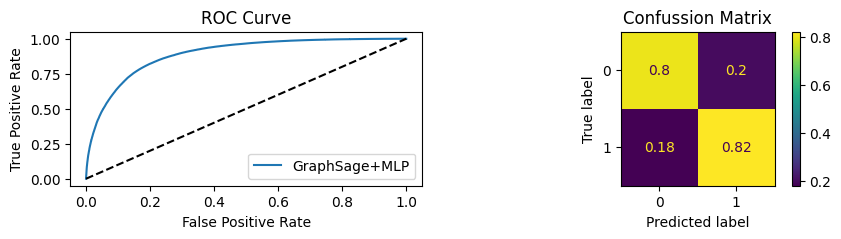


Evaluating Model with 60.0% of PPI's
 22284 Positive Protein Interactions were used to Embed a graph with 37140 ppi's
 8944 Positive Protein Interactions were used to Embed a graph with 14908 ppi's
 17079 Positive Protein Interactions were used to Embed a graph with 28466 ppi's
 9013 Positive Protein Interactions were used to Embed a graph with 15022 ppi's
 10336 Positive Protein Interactions were used to Embed a graph with 17228 ppi's
 15674 Positive Protein Interactions were used to Embed a graph with 26124 ppi's
 3170 Positive Protein Interactions were used to Embed a graph with 5284 ppi's
 3819 Positive Protein Interactions were used to Embed a graph with 6366 ppi's
 8922 Positive Protein Interactions were used to Embed a graph with 14870 ppi's
 4750 Positive Protein Interactions were used to Embed a graph with 7918 ppi's
Youdens  index: 0.4110 Sensitivity: 0.8645 Specificity: 0.8101


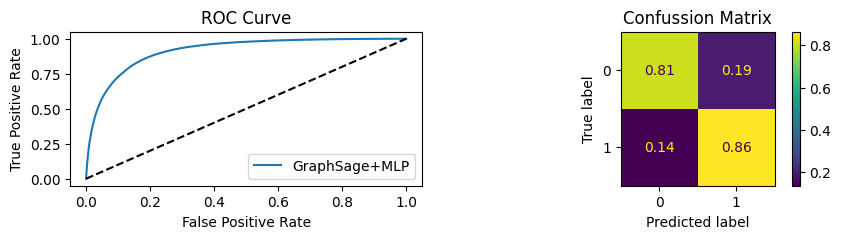


Evaluating Model with 70.0% of PPI's
 25998 Positive Protein Interactions were used to Embed a graph with 37140 ppi's
 10435 Positive Protein Interactions were used to Embed a graph with 14908 ppi's
 19926 Positive Protein Interactions were used to Embed a graph with 28466 ppi's
 10515 Positive Protein Interactions were used to Embed a graph with 15022 ppi's
 12059 Positive Protein Interactions were used to Embed a graph with 17228 ppi's
 18286 Positive Protein Interactions were used to Embed a graph with 26124 ppi's
 3698 Positive Protein Interactions were used to Embed a graph with 5284 ppi's
 4456 Positive Protein Interactions were used to Embed a graph with 6366 ppi's
 10409 Positive Protein Interactions were used to Embed a graph with 14870 ppi's
 5542 Positive Protein Interactions were used to Embed a graph with 7918 ppi's
Youdens  index: 0.4037 Sensitivity: 0.8886 Specificity: 0.8195


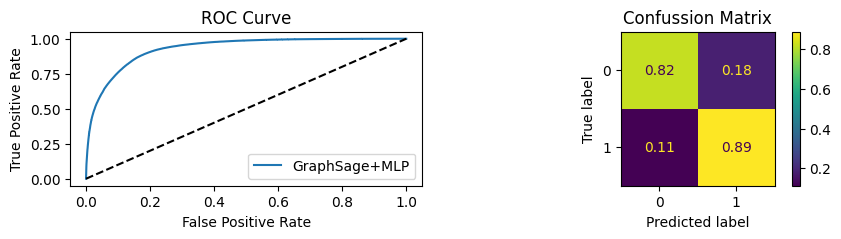


Evaluating Model with 80.0% of PPI's
 29712 Positive Protein Interactions were used to Embed a graph with 37140 ppi's
 11926 Positive Protein Interactions were used to Embed a graph with 14908 ppi's
 22772 Positive Protein Interactions were used to Embed a graph with 28466 ppi's
 12017 Positive Protein Interactions were used to Embed a graph with 15022 ppi's
 13782 Positive Protein Interactions were used to Embed a graph with 17228 ppi's
 20899 Positive Protein Interactions were used to Embed a graph with 26124 ppi's
 4227 Positive Protein Interactions were used to Embed a graph with 5284 ppi's
 5092 Positive Protein Interactions were used to Embed a graph with 6366 ppi's
 11896 Positive Protein Interactions were used to Embed a graph with 14870 ppi's
 6334 Positive Protein Interactions were used to Embed a graph with 7918 ppi's
Youdens  index: 0.5219 Sensitivity: 0.9028 Specificity: 0.8244


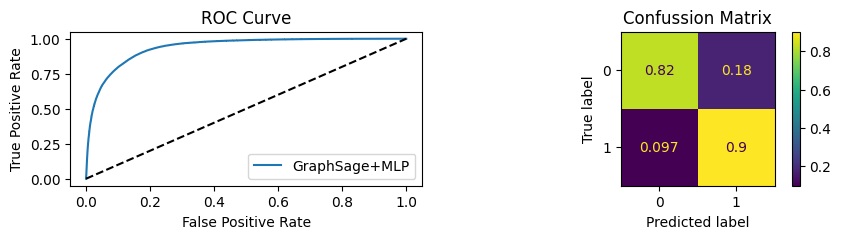


Evaluating Model with 90.0% of PPI's
 33426 Positive Protein Interactions were used to Embed a graph with 37140 ppi's
 13417 Positive Protein Interactions were used to Embed a graph with 14908 ppi's
 25619 Positive Protein Interactions were used to Embed a graph with 28466 ppi's
 13519 Positive Protein Interactions were used to Embed a graph with 15022 ppi's
 15505 Positive Protein Interactions were used to Embed a graph with 17228 ppi's
 23511 Positive Protein Interactions were used to Embed a graph with 26124 ppi's
 4755 Positive Protein Interactions were used to Embed a graph with 5284 ppi's
 5729 Positive Protein Interactions were used to Embed a graph with 6366 ppi's
 13383 Positive Protein Interactions were used to Embed a graph with 14870 ppi's
 7126 Positive Protein Interactions were used to Embed a graph with 7918 ppi's
Youdens  index: 0.6208 Sensitivity: 0.9041 Specificity: 0.8435


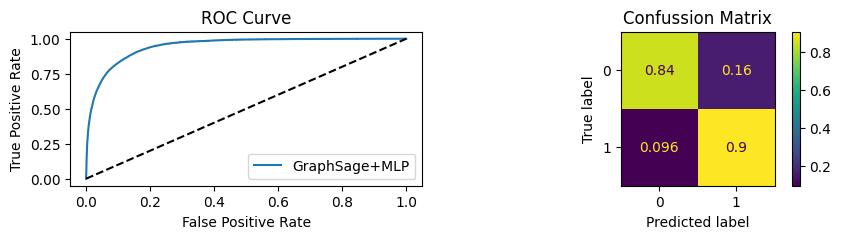

In [18]:
for i in [0.01, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    print(f"Evaluating Model with {i*100}% of PPI's")
    evaluate(model, link_predictor ,test_loader,device=device,ppi_=i,verbose=True,show_extra_metrics=True)
    print()

It's obvious that increaings the PPI percentage the model will learn more and get better accuracy. 

Okay! We trained a graph neural network that predict protein-protein interactions! 

It's important to mention two things: 

-   Big part of the code on this post is reused from the work of [Perez et al](https://github.com/Ale9806/BERT2SAGE_Enhancing_LLMs/blob/main/FINAL/Final_ProBERT2SAGE.ipynb). 
-   Perez et al. also trained a DistMult based prediction model (an ***a priori*** model) that doesn't need graph structure knowledge. I tried to implement this but, due to the small gene set (**Unfolded protei binding**), this model doesn't improve larger than 5% percent of accuracy. 

Finally, on the next post, I will use this trained model to predict the protein-protein interactions of the proteins expressed by identified genes in a transcriptomic experiment made on *Coffea arabica*.